# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from typing import List


import statsmodels.api as sm
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split, learning_curve, LearningCurveDisplay
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 

sns.set_style("whitegrid")
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)


# Constants

In [2]:
SEED = 10
OUTLIER_THRESH = 3
DOWNSAMPLED_MAJ_CLASS_RATIO = 0.90
OVERSAMPLED_MIN_CLASS_RATIO = 1
TEST_SIZE = 0.15
LR_EPOCHS = 300
MEANS_DISTANCE_THRESH = .3

# Data Exploration

In [3]:
data = pd.read_csv("data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
print(data.isna().value_counts())
data.describe()

Time   V1     V2     V3     V4     V5     V6     V7     V8     V9     V10    V11    V12    V13    V14    V15    V16    V17    V18    V19    V20    V21    V22    V23    V24    V25    V26    V27    V28    Amount  Class
False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False   False    284807
Name: count, dtype: int64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
# sns.pairplot(data)

## Visualizing distribution and outliers

In [6]:
def show_boxplots(d=pd.DataFrame(), x=[], y=None, r=8, c=4, size=[14,9], outlier_size=3, title='', legend=[]):
    """"""
    fig, ax = plt.subplots(r, c, figsize=size, constrained_layout=True)
    ranges = [(i,j) for i in range(r) for j in range(c)]
    if not y:
        for xi,(i,j) in zip(x,ranges):
            sns.boxplot(ax=ax[i,j], data=d, x=xi, fliersize=outlier_size)            
    else:
        for xi,(i,j) in zip(x,ranges):
            sns.boxplot(ax=ax[i,j], data=d, x=xi, y=y, orient='h', hue=y, fliersize=outlier_size)
            handles, labels = ax[i, j].get_legend_handles_labels()
            if legend: ax[i, j].legend(handles, legend, title="Class")
            if i*c+j+1<len(x) : ax[i, j].legend_.remove()
            if j!=0: ax[i, j].get_yaxis().set_visible(False)
    for k in range(len(x), r*c): ax[*ranges[k]].axis('off')
    fig.suptitle(title, size=18)

def show_violinplots(d=pd.DataFrame(), x=[], y=None, r=8, c=4, size=[14,9], split=False, title='', legend=[]):
    """"""
    fig, ax = plt.subplots(r, c, figsize=size, constrained_layout=True)
    ranges = [(i,j) for i in range(r) for j in range(c)]
    if not y:
        for xi,(i,j) in zip(x,ranges):
            sns.violinplot(ax=ax[i,j], data=d, x=xi, split=split, inner='quart')            
    else:
        for xi,(i,j) in zip(x,ranges):
            sns.violinplot(ax=ax[i,j], data=d, x=xi, y=y, orient='h', hue=y, split=split, inner='quart')
            handles, labels = ax[i, j].get_legend_handles_labels()
            if legend: ax[i, j].legend(handles, legend, title="Class")
            if i*c+j+1<len(x) : ax[i, j].legend_.remove()
            if j!=0: ax[i, j].get_yaxis().set_visible(False)
    for k in range(len(x), r*c): ax[*ranges[k]].axis('off')
    fig.suptitle(title, size=18)

def show_histplots(d=pd.DataFrame(), x=[], y=None, r=8, c=4, size=[14,9], title=''):
    """"""
    fig, ax = plt.subplots(r, c, figsize=size, constrained_layout=True)
    ranges = [(i,j) for i in range(r) for j in range(c)]
    if not y:
        for xi,(i,j) in zip(x,ranges):
            sns.histplot(ax=ax[i,j], data=d, x=xi, kde=True)
    else:
        for xi,(i,j) in zip(x,ranges):
            sns.histplot(ax=ax[i,j], data=d, x=xi, hue=y, kde=True)
    for k in range(len(x), r*c): ax[*ranges[k]].axis('off')
    fig.suptitle(title, size=18)

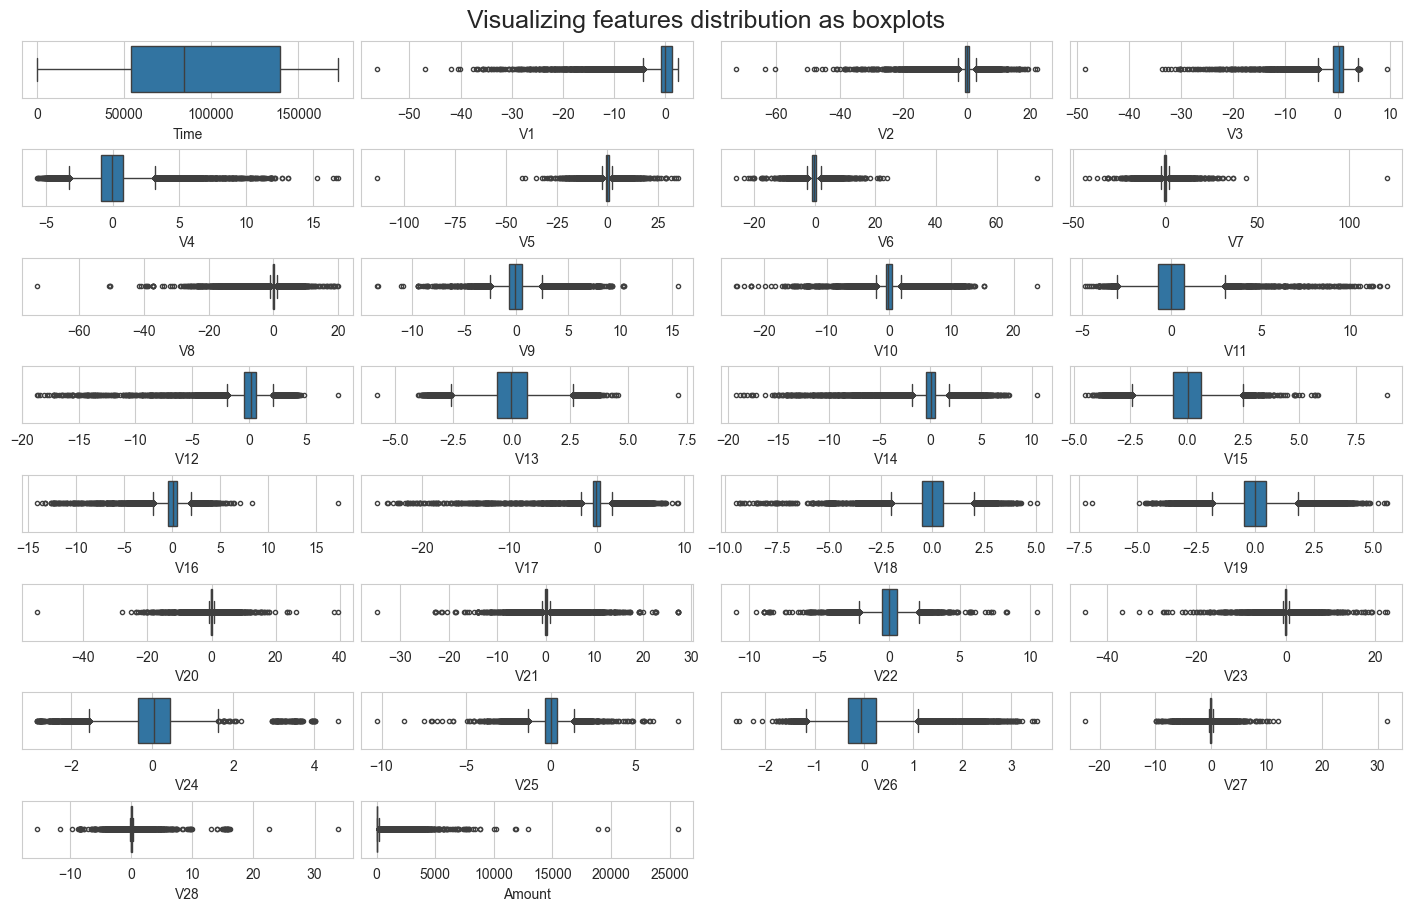

In [7]:
show_boxplots(d=data, x=data.columns[:-1], title='Visualizing features distribution as boxplots')

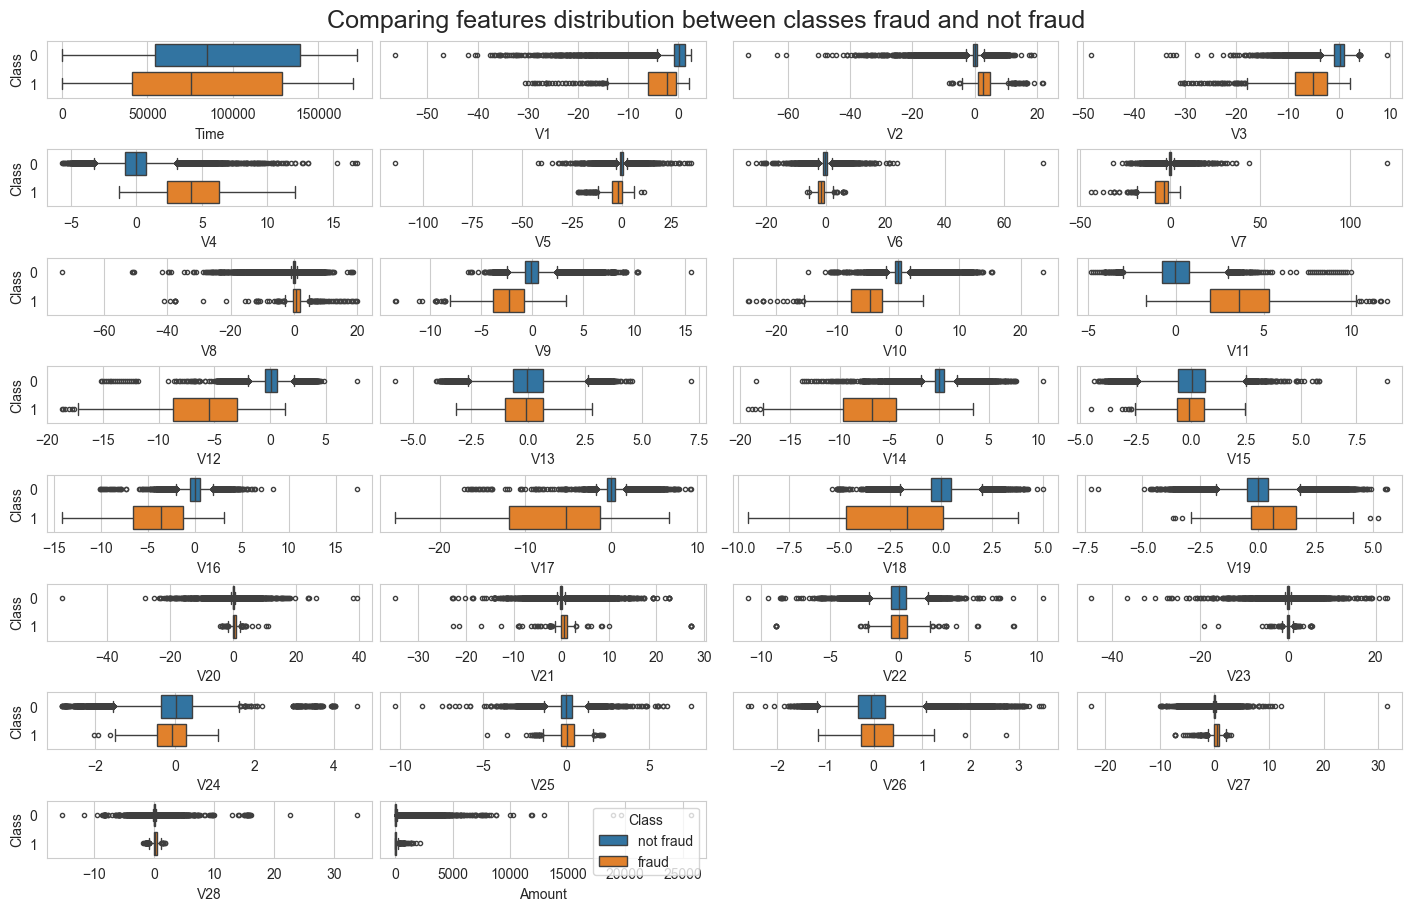

In [8]:
show_boxplots(d=data, x=data.columns[:-1], y='Class', title='Comparing features distribution between classes fraud and not fraud', legend=['not fraud', 'fraud'])

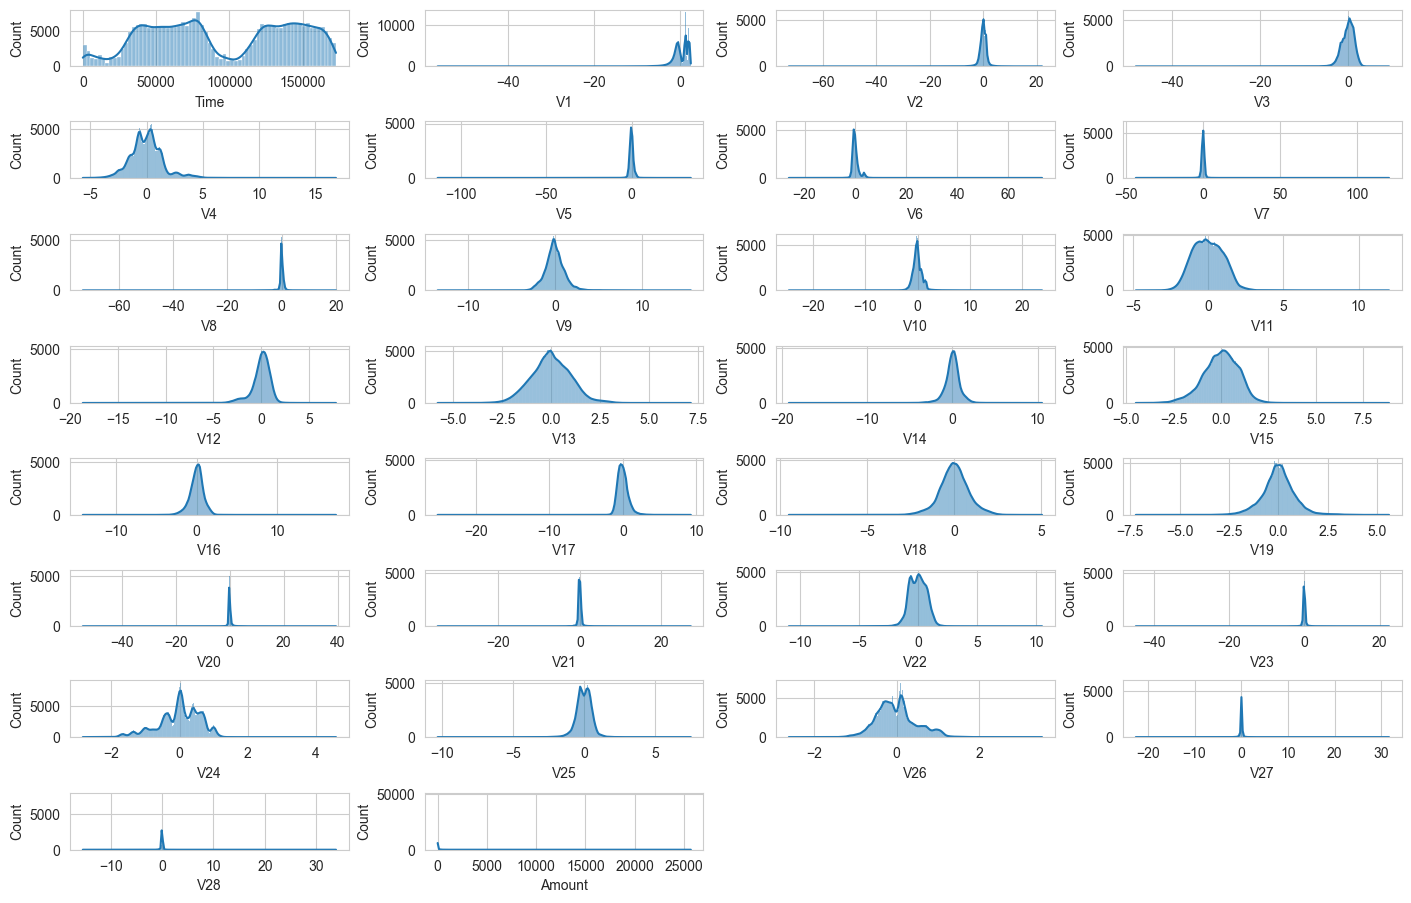

In [9]:
show_histplots(d=data, x=data.columns[:-1])

# Data Processing
## Removing a portion of outliers ( 1st downsampling step )
### Checking outlier percentage for each feature

In [10]:
iqr = data.quantile(.75) - data.quantile(.25)
minQ, maxQ = data.quantile(.25) - 1.5*iqr, data.quantile(.75) + 1.5*iqr
def feature_outlier_summary(data, minQ, maxQ, thresh=0.05, show=False):
    """"""
    out = []
    for i,col in enumerate(data.columns[:-1]):
        count = ((data[col] < minQ[i]) | (data[col] > maxQ[i])).sum()
        ratio = count / data.shape[0]
        if show: print(col, count, f'{ratio:.5f}', f'{1-ratio:.2f}', '***' if ratio<thresh else '', sep='\t')
        if ratio<0.05 : out.append(col)
    return np.array(out)
feature_outlier_summary(data, minQ, maxQ)

C:\Users\korda\AppData\Local\Temp\ipykernel_20020\3982423249.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count = ((data[col] < minQ[i]) | (data[col] > maxQ[i])).sum()


array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V7', 'V9', 'V10', 'V11',
       'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V22', 'V24',
       'V25', 'V26'], dtype='<U4')

### Visualizing percentage of majority class rows for each threshold of outlier presence

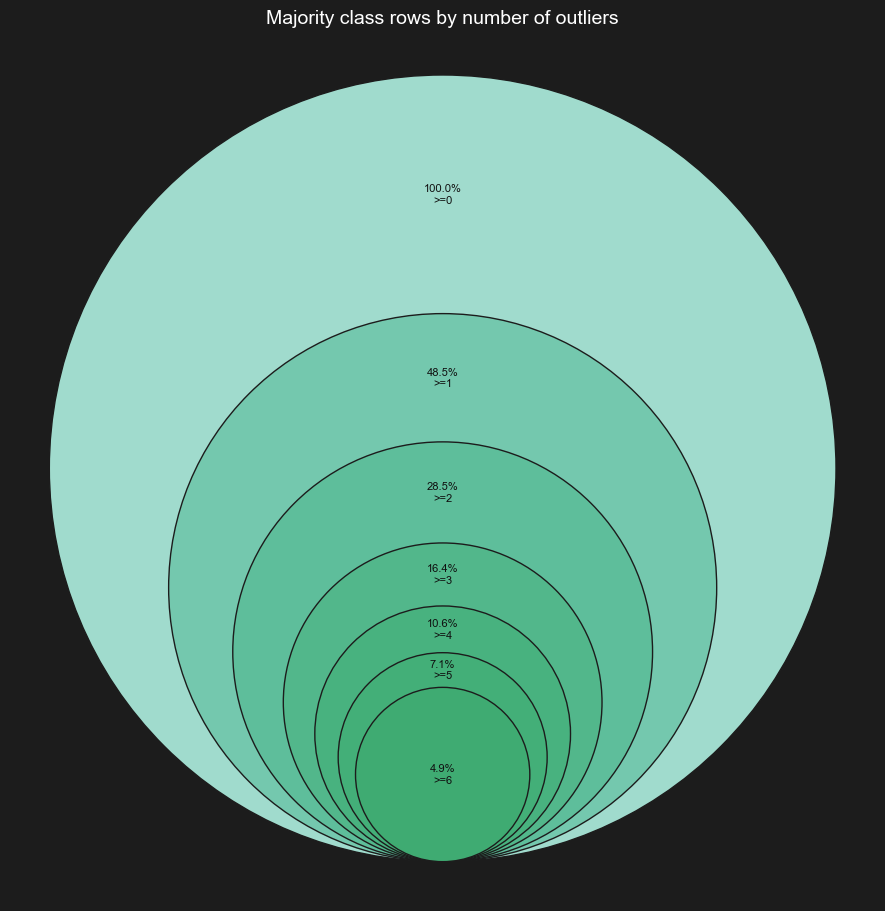

In [11]:
def outlier_rows_graph(data, min_quantile, max_quantile, n_outliers, title):
    """"""
    array_outliers = np.array((data[data.Class==0]<min_quantile) | (data[data.Class==0]>max_quantile)).sum(axis=1)
    perc_outliers = np.array([ (array_outliers>=i).sum()/data[data.Class==0].shape[0] for i in range(n_outliers) ])
    R = np.sqrt(perc_outliers)
    fig, ax = plt.subplots(figsize=(9,9), layout='constrained')
    p = [plt.Circle((0,r), radius=r) for r in R]
    col = PatchCollection(p, cmap='BuGn_r', norm=plt.Normalize(-.8, 2),
                           edgecolor='#1c1c1c')
    col.set_array(R)
    ax.add_collection(col)
    ax.set_aspect("equal"); ax.autoscale(); ax.axis("off")
    labels = [f'{round(o*100,1)}%\n>={i}' for i,o in enumerate(perc_outliers)]
    positions = [i+j for i,j in zip(R[:-1],R[1:])]
    positions.append(R[-1])
    for p,l in zip(positions, labels):
        ax.text(0, p, l, color="#101010", va="center", ha="center", size=8)
    fig.patch.set_facecolor('#1c1c1c')
    fig.suptitle(title, size=14, color='white')
outlier_rows_graph(data, minQ, maxQ, 7, 'Majority class rows by number of outliers')


In [12]:
def remove_outliers(data, minQ, maxQ, outlier_thresh=OUTLIER_THRESH, show=False):
    maj_class_data, min_class_data = data[data.Class==0], data[data.Class==1]
    array_outliers = np.array((maj_class_data<minQ) | (maj_class_data>maxQ)).sum(axis=1)
    if show:
        for i in range(16):
            outlier_rows = (array_outliers>=i).sum()
            print(i, outlier_rows, f'{outlier_rows/data.shape[0]:.2f}')
        (array_outliers==0).sum(), f'{(array_outliers==0).sum()/data.shape[0]:.3f}'
    clean_maj_data, outlier_maj_data = maj_class_data[array_outliers<=outlier_thresh], maj_class_data[array_outliers>outlier_thresh] 
    return pd.concat([clean_maj_data, min_class_data]).sort_index(), outlier_maj_data

def remove_outliers_all(data, minQ, maxQ, outlier_thresh=OUTLIER_THRESH, show=False):
    """"""
    array_outliers = np.array((data<minQ) | (data>maxQ)).sum(axis=1)
    if show:
        for i in range(16):
            outlier_rows = (array_outliers>=i).sum()
            print(i, outlier_rows, f'{outlier_rows/data.shape[0]:.2f}')
        (array_outliers==0).sum(), f'{(array_outliers==0).sum()/data.shape[0]:.3f}'
    normal_data, outlier_data = data[array_outliers<=outlier_thresh], data[array_outliers>outlier_thresh] 
    return normal_data, outlier_data

### Removing rows if the number of outliers exceeds the set threshold 

In [13]:
clean_data, outlier_maj_data = remove_outliers(data, minQ, maxQ)
features, target = clean_data[clean_data.columns[1:-1]], clean_data.Class
features.shape, sum(target)

((254768, 29), 492)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=TEST_SIZE, stratify=target, random_state=SEED)

## Hybrid sampling approach
### Downsampting from 99.8-0.2 to 90-10 ( 2nd step )

In [15]:
def get_downsampling_factor(data, maj_ratio=DOWNSAMPLED_MAJ_CLASS_RATIO):
    """"""
    min_ratio = round(sum(data.Class if isinstance(data, pd.DataFrame) else data)/data.shape[0],3)
    max_ratio = 1-min_ratio
    max_ratio_new = maj_ratio
    return (max_ratio/max_ratio_new - max_ratio)/min_ratio, int(max_ratio_new / (1-max_ratio_new))

def downsample(x_train, y_train, ratio):
    """"""
    x_train_maj, y_train_maj = resample(x_train[y_train==0], y_train[y_train==0], replace=False, n_samples=int(sum(y_train)*ratio), random_state=10)
    return shuffle(pd.concat([x_train_maj, x_train[y_train==1]]), pd.concat([y_train_maj, y_train[y_train==1]]), random_state=SEED)

downsample_factor, sample_ratio = get_downsampling_factor(clean_data)
x_train_, y_train_ = downsample(x_train, y_train, sample_ratio)
x_train_.shape, sum(y_train_)


((4180, 29), 418)

### Checking for distribution changes ( all classes )

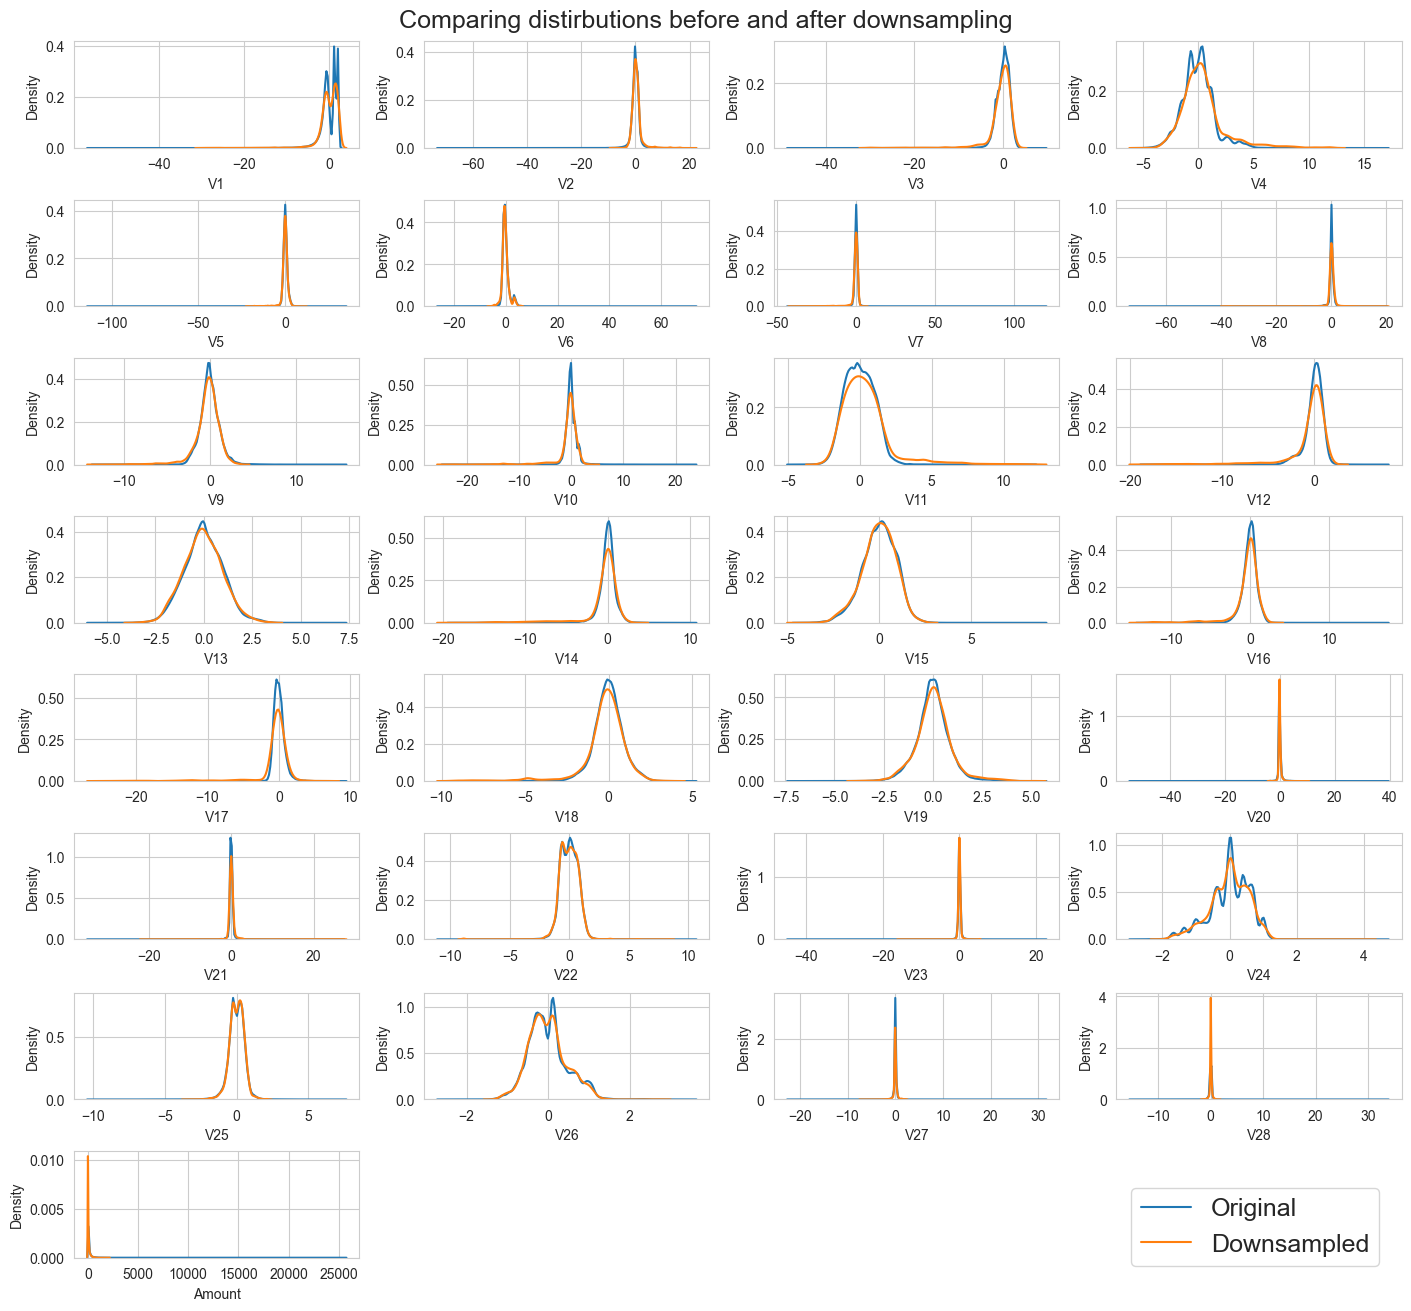

In [16]:
def compare_distributions(d1, d2, x=[], r=8, c=4, size=[14,13], only_kde=False, legend=['Original', 'Downsampled'], title=''):
    """"""
    fig, ax = plt.subplots(r, c, figsize=size, constrained_layout=True)
    ranges = [(i,j) for i in range(r) for j in range(c)]
    if only_kde:
        for xi,(i,j) in zip(x,ranges):
            sns.kdeplot(ax=ax[i,j], data=d1, x=xi, label=legend[0])
            sns.kdeplot(ax=ax[i,j], data=d2, x=xi, label=legend[1])
    else:
        for xi,(i,j) in zip(x,ranges):
            sns.histplot(ax=ax[i,j], data=d1, x=xi, stat='density', kde=True, label=legend[0])
            sns.histplot(ax=ax[i,j], data=d2, x=xi, stat='density', kde=True, label=legend[1])
    for k in range(len(x), r*c): ax[*ranges[k]].axis('off')
    handles, labels = ax[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=18, bbox_to_anchor=(.99, .1))
    fig.suptitle(title, size=18)
    
compare_distributions(data, x_train_, x=data.columns[1:-1], only_kde=True, title='Comparing distirbutions before and after downsampling')

# Modeling & Evalutation
### Oversampling Minority Class ( SMOTE vs ADASYN )
#### SMOTE 50-50

In [17]:
def show_learning_curve(model ,X, Y, metrics, cv=5, train_sizes=np.linspace(0.15, 1.0, 40), r=1, c=3, title='', size=[14,4], s=4):
    fig, ax = plt.subplots(r,c, figsize=size)
    for i, metric in enumerate(metrics):
        LearningCurveDisplay.from_estimator(
            model, X, Y, cv=cv, 
            scoring=metric, line_kw={"marker": "o", "markersize": s},
            train_sizes=train_sizes, n_jobs=-1, ax=ax[i])

def eval_model(X, Y, model, funcs='auto', fbeta:List[float]=[3,5,10]): 
    if funcs=='auto' : funcs=['precision_score', 'recall_score', 'roc_auc_score', 'average_precision_score', 'f1_score']
    d = {func : eval('metrics.'+func)(Y, model.predict(X)) for func in funcs }
    if fbeta : 
        for beta in fbeta : 
            d['fbeta_score_'+str(beta)] = metrics.fbeta_score(Y, model.predict(X), beta=beta)
    return pd.Series(d) 

def train(X_train, Y_train, model, oversampler, scaling=True):
    if oversampler is not None: 
        x_train, y_train = shuffle(*oversampler.fit_resample(X_train, Y_train), random_state=SEED)
    else: x_train, y_train = X_train.copy(), Y_train.copy()
    if scaling :
        scaler = StandardScaler()
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
    clf_model = model.fit(x_train, y_train)
    return clf_model, x_train, y_train, scaler if scaling else None 

##### Checking for distribution changes ( minority class ) 
##### & Modeling using non-standardized training data

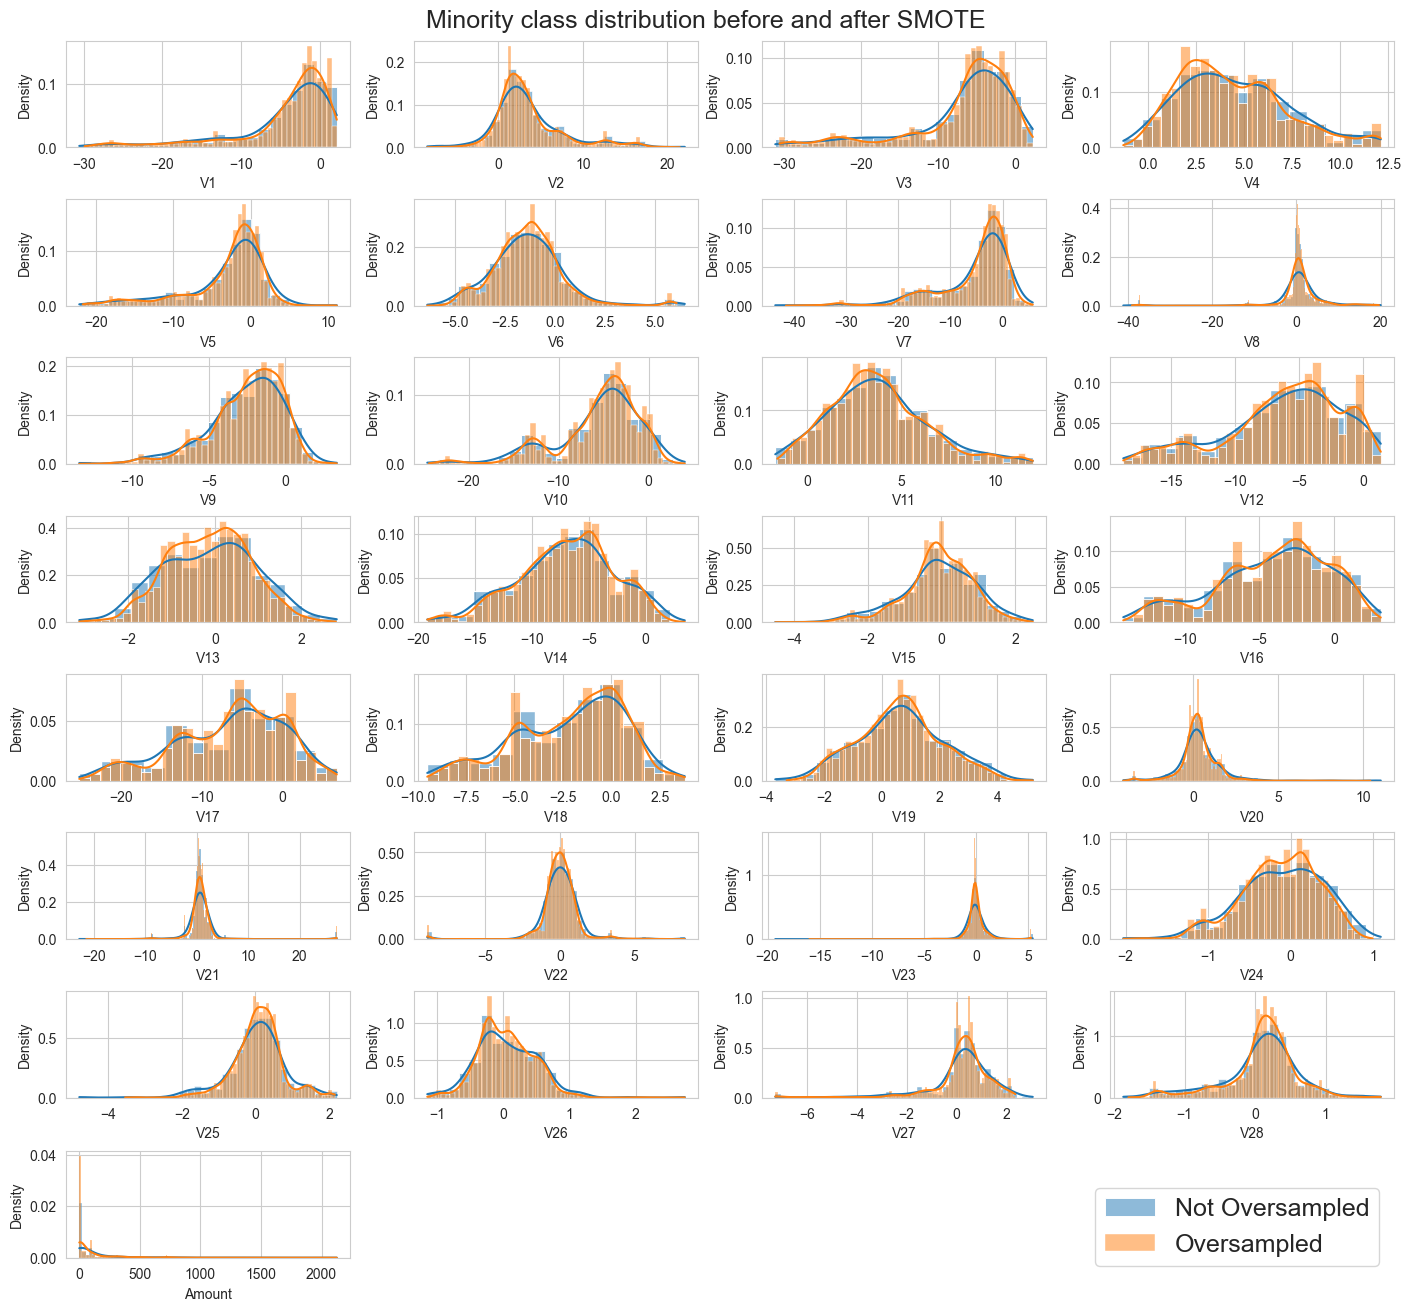

In [18]:
smote = SMOTE(sampling_strategy=OVERSAMPLED_MIN_CLASS_RATIO, random_state=SEED, k_neighbors=7)
LR_model = LogisticRegression(class_weight={0: downsample_factor, 1: 1}, penalty='l2', random_state=SEED, max_iter=LR_EPOCHS)
clf, x_train_smote, y_train_smote, scaler = train(x_train_, y_train_, LR_model, smote, scaling=False) 
if not scaler:
    compare_distributions(data[data.Class==1], x_train_smote[y_train_smote==1], x=data.columns[1:-1], legend=['Not Oversampled', 'Oversampled'], title='Minority class distribution before and after SMOTE')
x_test_ = scaler.transform(x_test) if scaler else x_test

##### SMOTE Model evaluation ( non-standardized data )

,precision_score,recall_score,roc_auc_score,average_precision_score,f1_score,fbeta_score_3,fbeta_score_5,fbeta_score_10
0,0.821429,0.932432,0.96602,0.766057,0.873418,0.92,0.927611,0.931187


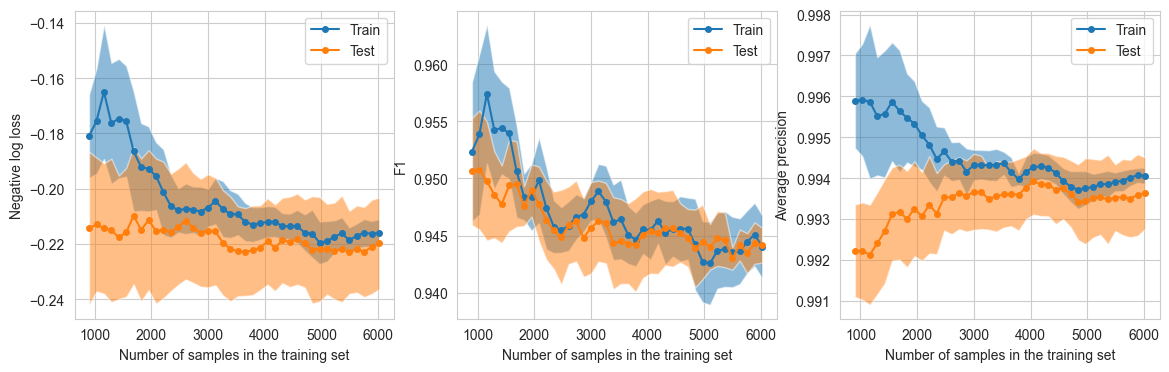

In [19]:
show_learning_curve(LR_model, x_train_smote, y_train_smote, ['neg_log_loss' ,'f1', 'average_precision'])
smote_metrics_ns = eval_model(x_test_, y_test, clf)
pd.DataFrame(smote_metrics_ns).T

##### SMOTE Model evaluation ( standardized data )

,precision_score,recall_score,roc_auc_score,average_precision_score,f1_score,fbeta_score_3,fbeta_score_5,fbeta_score_10
0,0.932432,0.932432,0.966151,0.869561,0.932432,0.932432,0.932432,0.932432


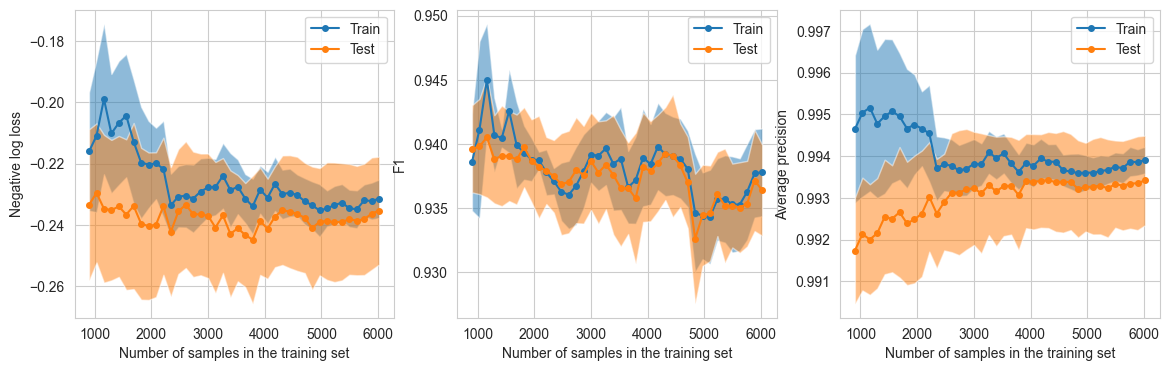

In [20]:
clf, x_train_smote, y_train_smote, scaler = train(x_train_, y_train_, LR_model, smote) 
x_test_ = scaler.transform(x_test) if scaler else x_test
smote_metrics_s = eval_model(x_test_, y_test, clf)
show_learning_curve(LR_model, x_train_smote, y_train_smote, ['neg_log_loss' ,'f1', 'average_precision'])
pd.DataFrame(smote_metrics_s).T

##### Visualizing distributions per class 
Checking for similarities in distributions 

Index(['V8', 'V13', 'V15', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26',
       'V27', 'V28', 'Amount'],
      dtype='object')

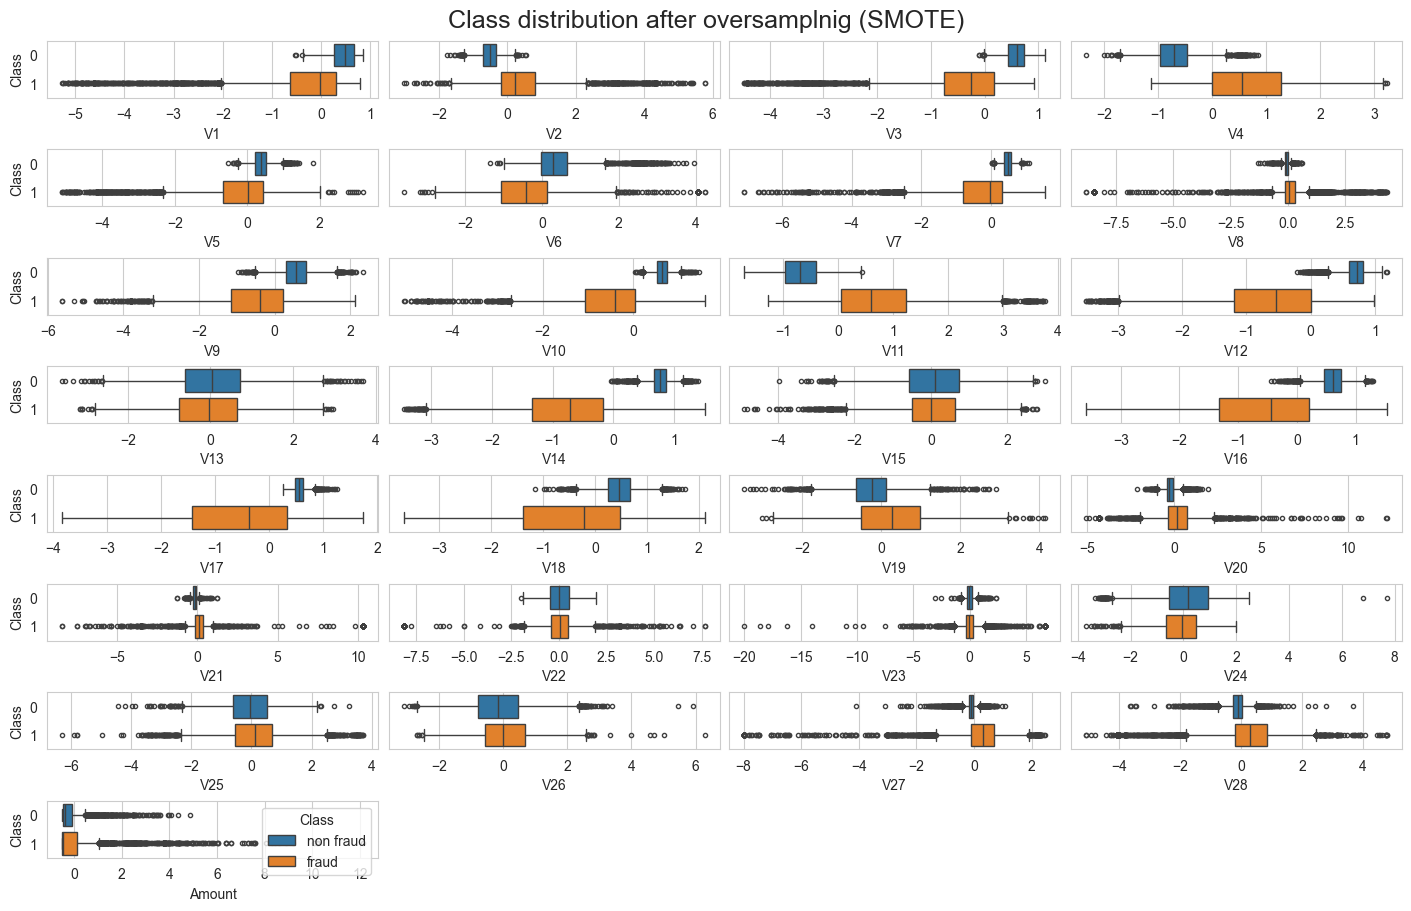

In [21]:
def find_removable_featues(data, mean_thresh=MEANS_DISTANCE_THRESH, std_thresh=0, show=False):
    mean_diff = (data[data.Class==0].mean() - data[data.Class==1].mean())[:-1].abs()
    mean_diff = mean_diff/mean_diff.max()
    if show: print(mean_diff)
    if std_thresh>0:
        std_diff = (data[data.Class==0].std() - data[data.Class==1].std())[:-1].abs()
        std_diff = (std_diff)/std_diff.max()
        if show: print(std_diff)
        return  list(set(mean_diff[mean_diff < mean_thresh].index).intersection(mean_diff[mean_diff < mean_thresh].index))
    return mean_diff[mean_diff < mean_thresh].index

clf, x_train_smote, y_train_smote, scaler = train(x_train_, y_train_, LR_model, smote) 
new_data = pd.DataFrame(x_train_smote, columns=x_train_.columns)
new_data['Class'] = y_train_smote.reset_index(drop=True)
show_boxplots(d=new_data, x=new_data.columns[:-1], y='Class', legend=['non fraud', 'fraud'], title='Class distribution after oversamplnig (SMOTE)')
minor_feat = find_removable_featues(new_data)
minor_feat

##### Modeling & Evaluaton for SMOTE data with less features

,precision_score,recall_score,roc_auc_score,average_precision_score,f1_score,fbeta_score_3,fbeta_score_5,fbeta_score_10
0,0.971831,0.932432,0.96619,0.906298,0.951724,0.936228,0.933889,0.932807


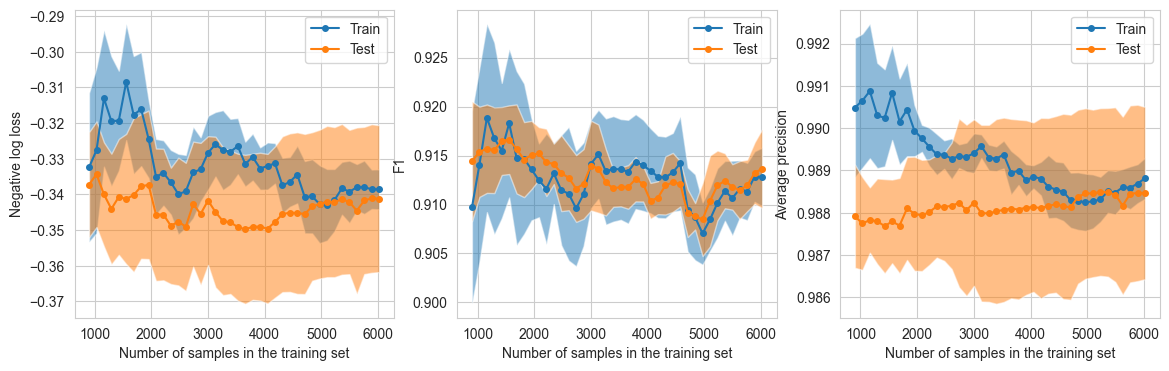

In [22]:
clf, x_train_smote, y_train_smote, scaler = train(x_train_.drop(columns=minor_feat), y_train_, LR_model, smote) 
x_test_ = scaler.transform(x_test.drop(columns=minor_feat))
smote_metrics_s_r = eval_model(x_test_, y_test, clf)
show_learning_curve(LR_model, x_train_smote, y_train_smote, ['neg_log_loss' ,'f1', 'average_precision'])
pd.DataFrame(smote_metrics_s_r).T

#### Comparing SMOTE models

In [23]:
def compare_model_results(data, x, y, r=4, c=2, size=[14,9], title=''):
    fig, ax = plt.subplots(r,c,figsize=size, constrained_layout=True)
    ranges = [(i,j) for i in range(r) for j in range(c)]
    ylim_min, ylim_max = data.drop(columns=[x]).min().min(), data.drop(columns=[x]).max().max()
    for _, (i,j) in zip(y, ranges):
        sns.pointplot(ax=ax[(i,j) if r>1 else j], data=data, x=x, y=_)
        ax[(i,j) if r>1 else j].set_ylim(ylim_min-.05, ylim_max+.05)
    for k in range(len(y), r*c): ax[(ranges[k][0], ranges[k][1]) if r>1 else ranges[k][1]].axis('off')
    fig.suptitle(title, size=18)


,precision_score,recall_score,roc_auc_score,average_precision_score,f1_score,fbeta_score_3,fbeta_score_5,fbeta_score_10,data
smote_ns,0.821429,0.932432,0.966020,0.766057,0.873418,0.920000,0.927611,0.931187,Non-standardized
smote_s,0.932432,0.932432,0.966151,0.869561,0.932432,0.932432,0.932432,0.932432,Standardized
smote_s_r,0.971831,0.932432,0.966190,0.906298,0.951724,0.936228,0.933889,0.932807,Standardized + Reduced


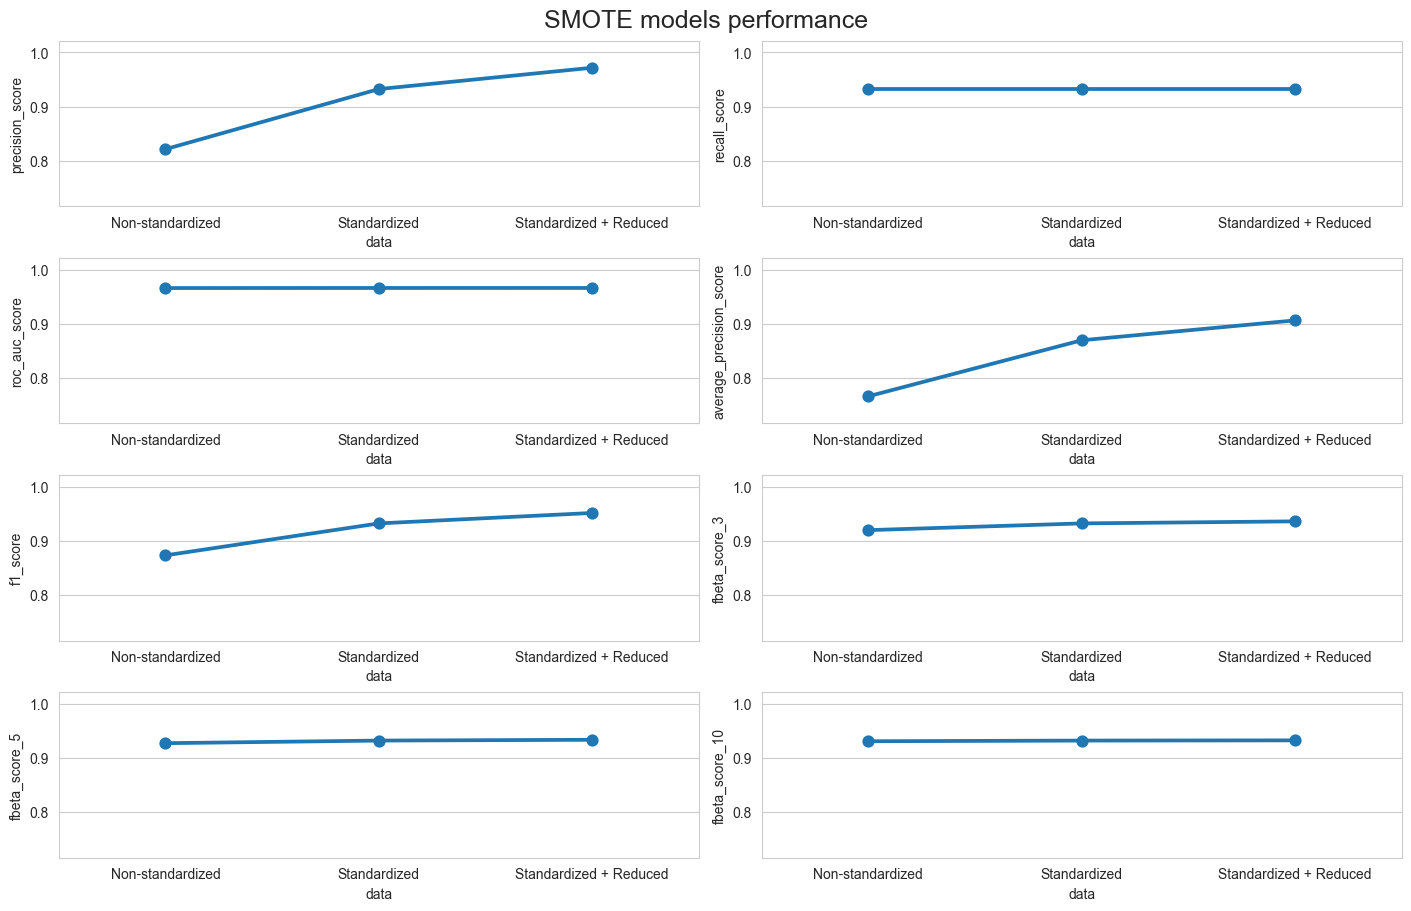

In [24]:
smote_metrics_data = pd.DataFrame({'smote_ns' : smote_metrics_ns,
                      'smote_s' : smote_metrics_s,
                      'smote_s_r' : smote_metrics_s_r }).T
smote_metrics_data['data'] = ['Non-standardized', 'Standardized', 'Standardized + Reduced']
compare_model_results(smote_metrics_data, x='data', y=smote_metrics_data.columns[:-1], title='SMOTE models performance')
smote_metrics_data

#### ADASYN
##### Checking for distribution changes ( minority class ) 
##### & Modeling using non-standardized training data

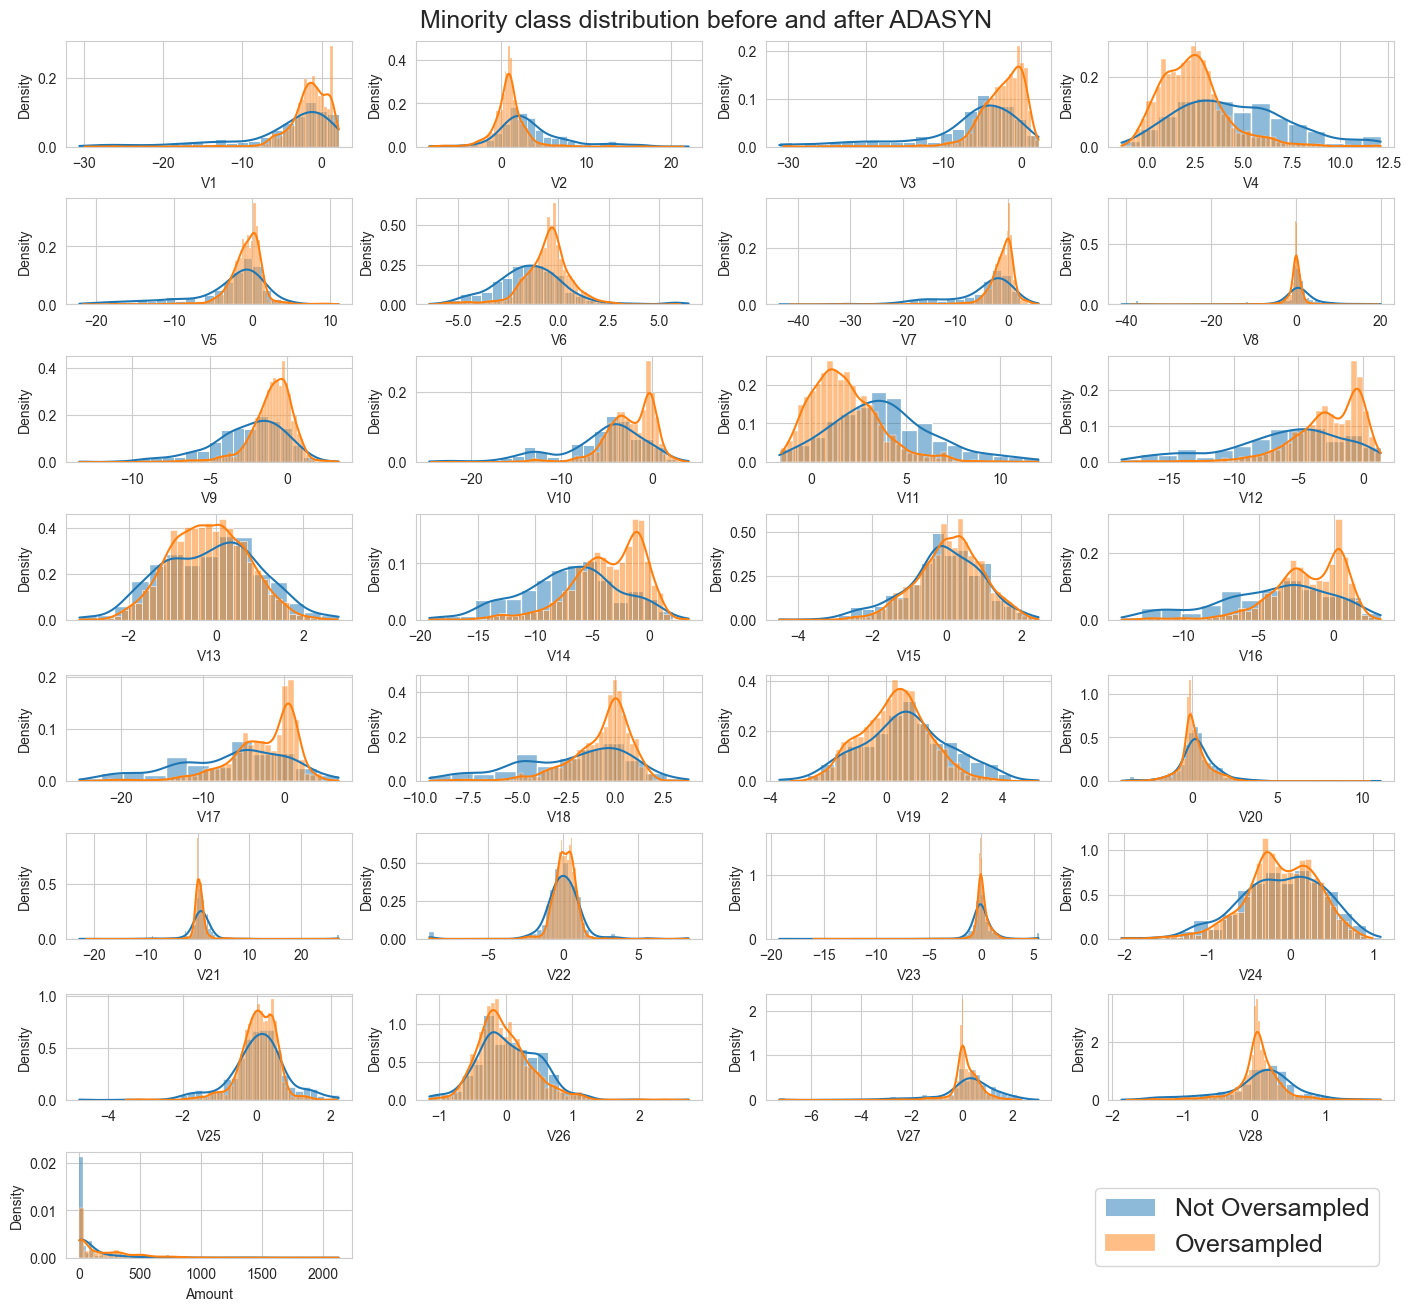

In [25]:
LR_model = LogisticRegression(class_weight={0: downsample_factor, 1: 1}, penalty='l2', random_state=SEED, max_iter=800)
adasyn = ADASYN(sampling_strategy=OVERSAMPLED_MIN_CLASS_RATIO, random_state=SEED, n_neighbors=7)
clf, x_train_adasyn, y_train_adasyn, scaler = train(x_train_, y_train_, LR_model, adasyn, scaling=False) 
if not scaler:
    compare_distributions(data[data.Class==1], x_train_adasyn[y_train_adasyn==1], x=data.columns[1:-1], legend=['Not Oversampled', 'Oversampled'], title='Minority class distribution before and after ADASYN')
x_test_ = scaler.transform(x_test) if scaler else x_test

##### ADASYN Model evaluation ( non-standardized data )

,precision_score,recall_score,roc_auc_score,average_precision_score,f1_score,fbeta_score_3,fbeta_score_5,fbeta_score_10
0,0.673077,0.945946,0.972527,0.636799,0.786517,0.909091,0.931423,0.942164


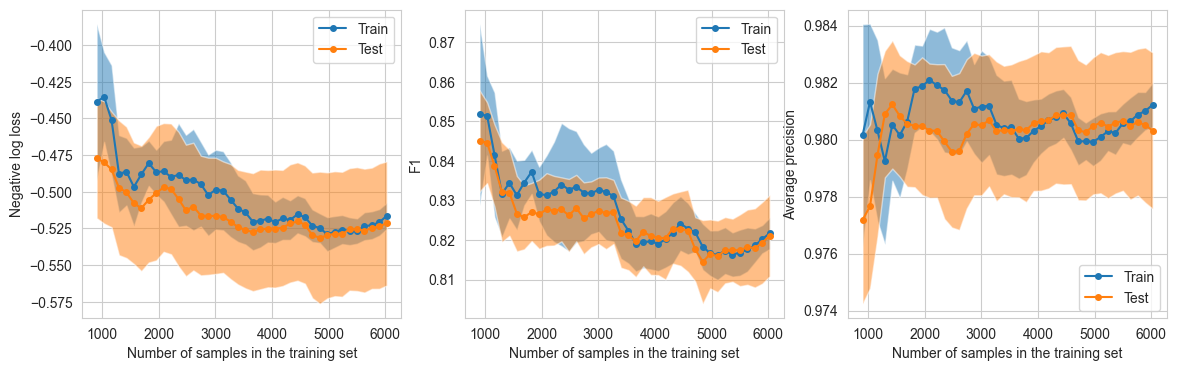

In [26]:
show_learning_curve(LR_model, x_train_adasyn, y_train_adasyn, ['neg_log_loss' ,'f1', 'average_precision'])
adasyn_metrics_ns = eval_model(x_test_, y_test, clf)
pd.DataFrame(adasyn_metrics_ns).T

##### ADASYN Model evaluation ( standardized data )

,precision_score,recall_score,roc_auc_score,average_precision_score,f1_score,fbeta_score_3,fbeta_score_5,fbeta_score_10
0,0.648148,0.945946,0.972475,0.613218,0.769231,0.904393,0.92952,0.941662


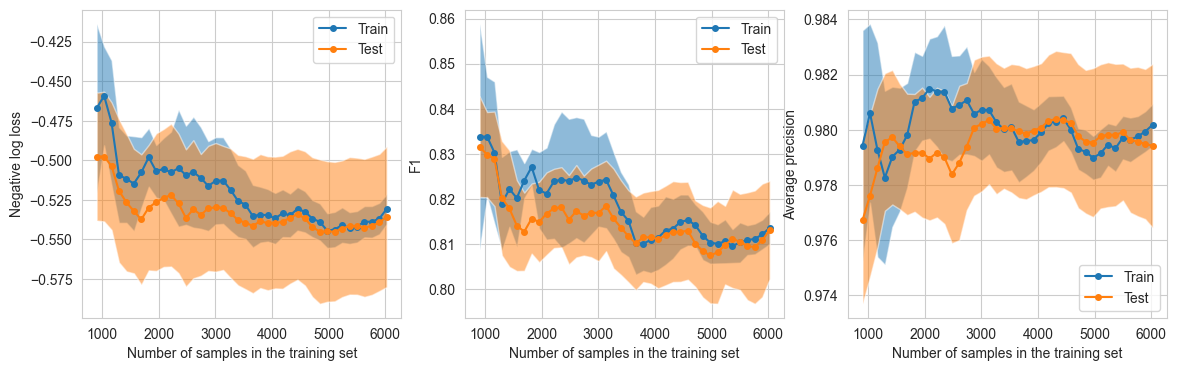

In [27]:
clf, x_train_adasyn, y_train_adasyn, scaler = train(x_train_, y_train_, LR_model, adasyn) 
x_test_ = scaler.transform(x_test) if scaler else x_test
adasyn_metrics_s = eval_model(x_test_, y_test, clf)
show_learning_curve(LR_model, x_train_adasyn, y_train_adasyn, ['neg_log_loss' ,'f1', 'average_precision'])
pd.DataFrame(adasyn_metrics_s).T

,precision_score,recall_score,roc_auc_score,average_precision_score,f1_score,fbeta_score_3,fbeta_score_5,fbeta_score_10,data
adasyn_ns,0.673077,0.945946,0.972527,0.636799,0.786517,0.909091,0.931423,0.942164,Non-standardized
adasyn_s,0.648148,0.945946,0.972475,0.613218,0.769231,0.904393,0.929520,0.941662,Standardized


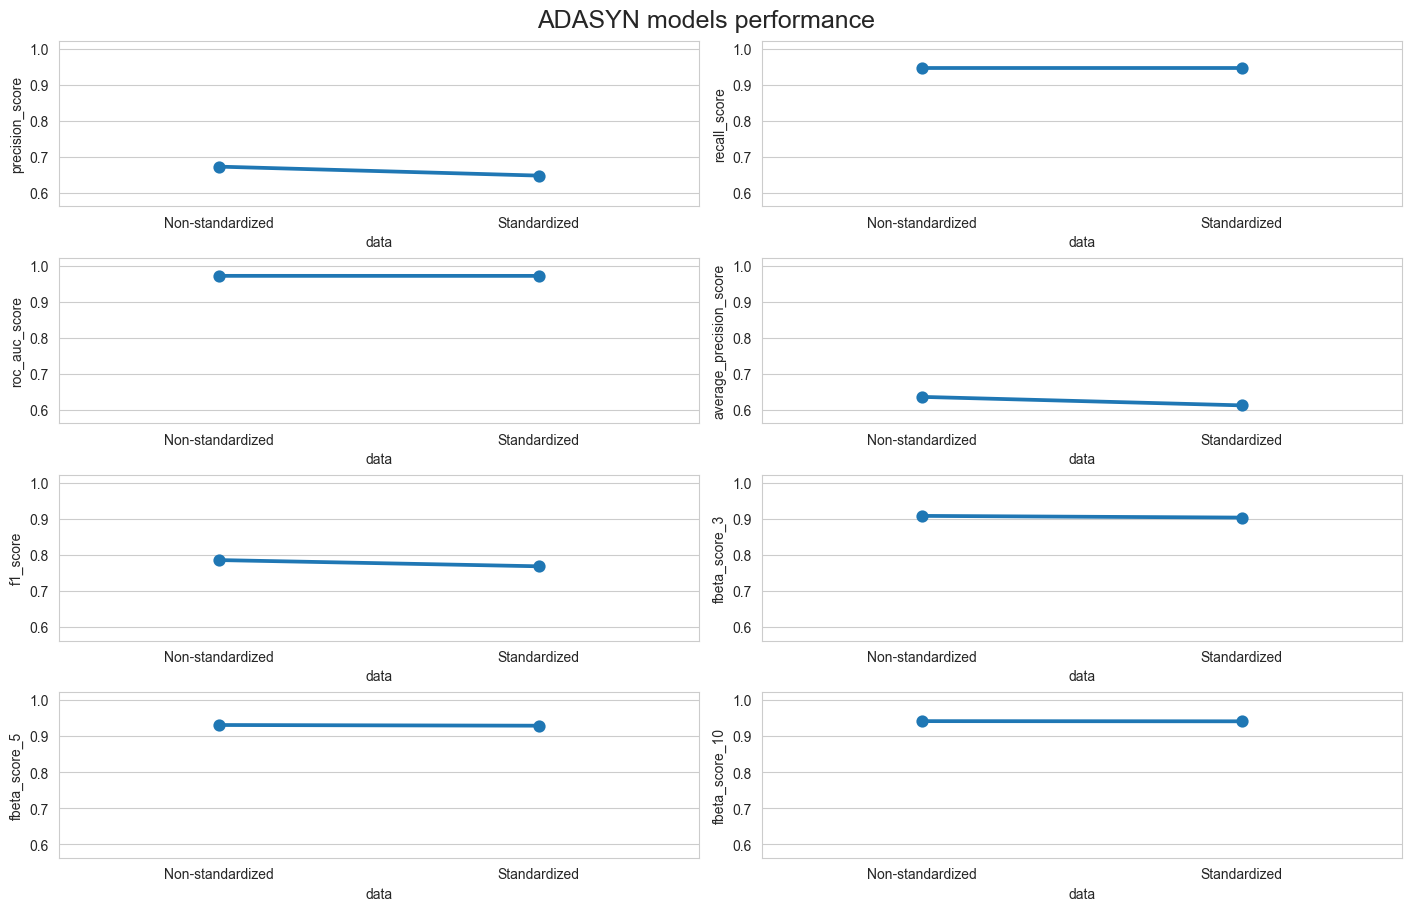

In [28]:
adasyn_metrics_data = pd.DataFrame({'adasyn_ns' : adasyn_metrics_ns,
                      'adasyn_s' : adasyn_metrics_s }).T
adasyn_metrics_data['data'] = ['Non-standardized', 'Standardized']
compare_model_results(adasyn_metrics_data, x='data', y=adasyn_metrics_data.columns[:-1], title='ADASYN models performance')
adasyn_metrics_data

#### P-values for limited features dataset

In [29]:
# clf, x_train_smote, y_train_smote, scaler = train(x_train_, y_train_, LR_model, smote) 
clf, x_train_smote, y_train_smote, scaler = train(x_train_.drop(columns=minor_feat), y_train_, LR_model, smote) 
sm_logit_model = sm.Logit(y_train_smote, sm.add_constant(x_train_smote))
sm_res = sm_logit_model.fit(maxiter=300)
pd.DataFrame({'coef':sm_res.params, 'p-values':round(sm_res.pvalues,4)})


Optimization terminated successfully.
         Current function value: 0.122016
         Iterations 17


,coef,p-values
const,162.455123,0.0
x1,-10.129545,0.0
x2,1.644806,0.0
x3,-21.730844,0.0
x4,9.954043,0.0
x5,-8.930160,0.0
x6,-1.216623,0.0
x7,-23.224774,0.0
x8,-5.798593,0.0
x9,-26.518120,0.0


# Finetuning
## Dealing with removed outliers

In [30]:
# ##### Alternative Split ( splitting all classes into normal and outliers )
# outlier_feat, outlier_target = outlier_maj_data.drop(columns=['Time','Class']), outlier_maj_data.Class
# x_train_out, x_test_out, y_train_out, y_test_out = train_test_split(outlier_feat, outlier_target, test_size=TEST_SIZE, random_state=SEED)
# _, x_out_tmp = remove_outliers_all(pd.concat((x_train[y_train==1], y_train[y_train==1]), axis=1), minQ[1:], maxQ[1:])
# x_train_out, x_test_out = pd.concat([x_train_out, x_out_tmp.drop(columns=['Class'])]), pd.concat([x_test_out, x_test[y_test==1]])
# y_train_out, y_test_out = pd.concat([y_train_out, y_train[x_out_tmp.index]]), pd.concat([y_test_out, y_test[y_test==1]])

In [31]:
outlier_feat, outlier_target = outlier_maj_data.drop(columns=['Time','Class']), outlier_maj_data.Class
x_train_out, x_test_out, y_train_out, y_test_out = train_test_split(outlier_feat, outlier_target, test_size=TEST_SIZE, random_state=SEED)
x_train_out, x_test_out = pd.concat([x_train_out, x_train[y_train==1]]), pd.concat([x_test_out, x_test[y_test==1]])
y_train_out, y_test_out = pd.concat([y_train_out, y_train[y_train==1]]), pd.concat([y_test_out, y_test[y_test==1]])

### Visualizing distributions per class 
Checking for class identifying differences in distributions 

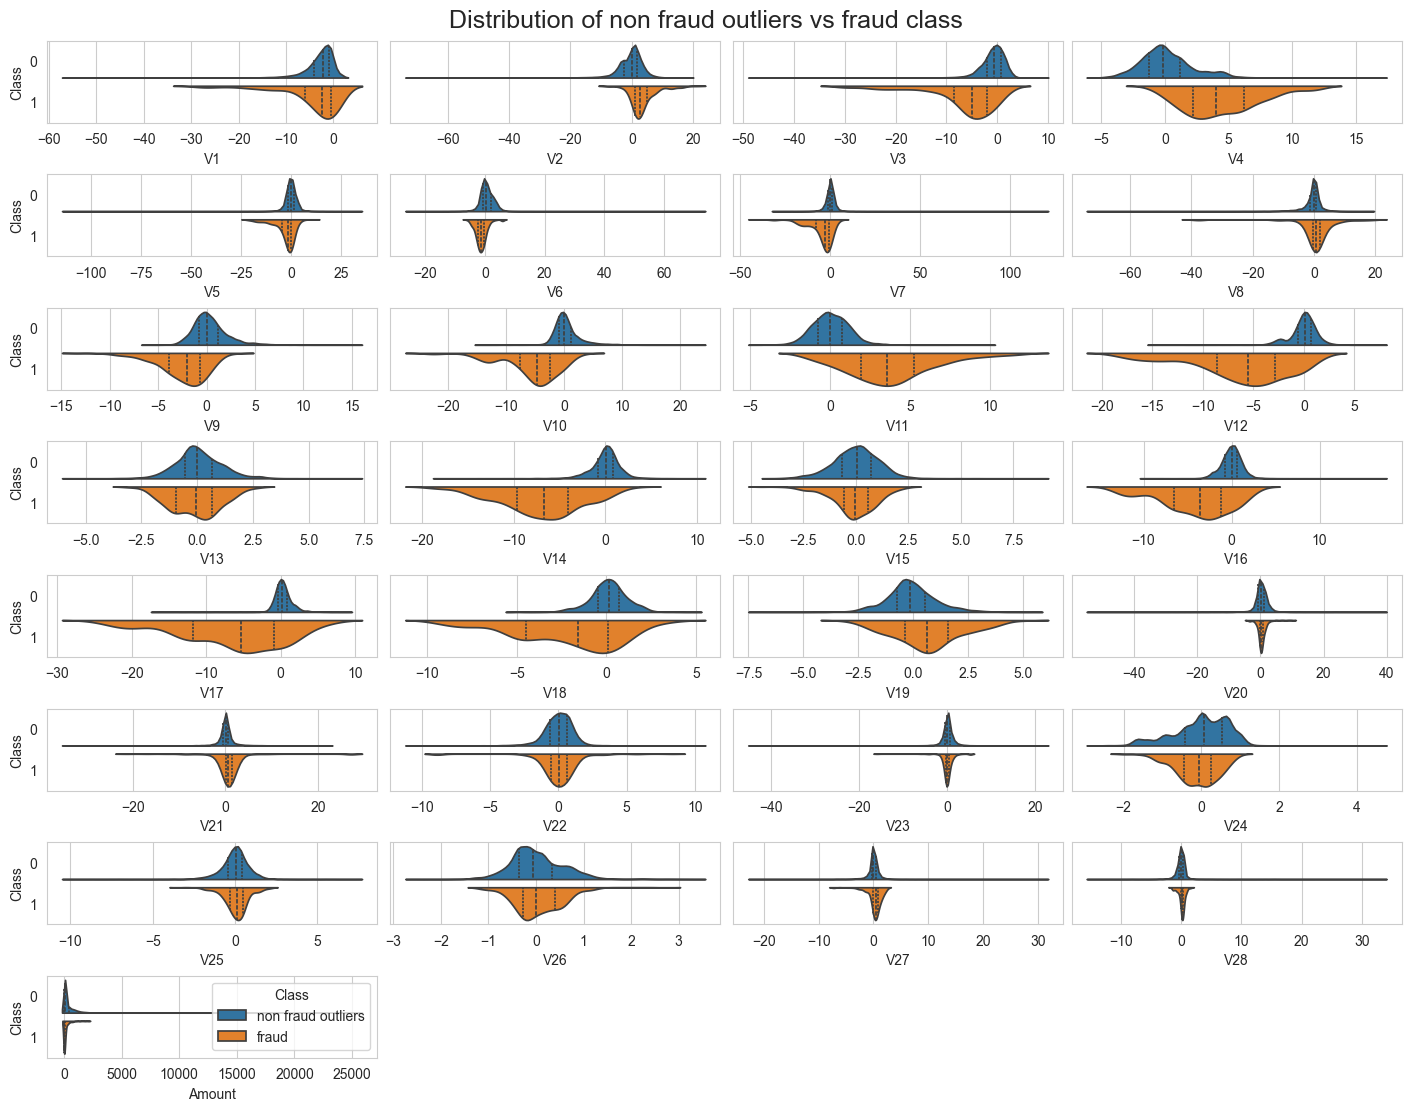

In [32]:
final_outlier_data = x_train_out.copy()
final_outlier_data['Class'] = y_train_out
show_violinplots(d=final_outlier_data, x=final_outlier_data.columns[:-1], y='Class', size=[14,11], split=True, legend=['non fraud outliers', 'fraud'], title='Distribution of non fraud outliers vs fraud class')

### Downsampling majority class

In [33]:
downsample_factor_out, sample_ratio_out = get_downsampling_factor(final_outlier_data, .8)
x_train_out_, y_train_out_ = downsample(x_train_out, y_train_out, sample_ratio_out)
x_train_out_.shape

(2090, 29)

### Oversampling (SMOTE) & Model training

In [34]:
smote = SMOTE(sampling_strategy=OVERSAMPLED_MIN_CLASS_RATIO, random_state=SEED, k_neighbors=7)
LR_model_2 = LogisticRegression(class_weight={0: downsample_factor_out, 1: 1}, penalty='l2', random_state=SEED, max_iter=LR_EPOCHS)
clf_out, x_train_out_smote, y_train_out_smote, scaler_out = train(x_train_out_, y_train_out_, LR_model_2, smote) 
smote_metrics_s_out = eval_model(scaler_out.transform(x_test_out), y_test_out, clf_out)
display(pd.DataFrame(smote_metrics_s_out).T)
# show_learning_curve(LR_model_2, x_train_out_smote, y_train_out_smote, ['neg_log_loss' , 'f1', 'average_precision'])

newOutData = pd.DataFrame(x_train_out_smote, columns=x_train_out_.columns)
newOutData['Class'] = y_train_out_smote.reset_index(drop=True)

,precision_score,recall_score,roc_auc_score,average_precision_score,f1_score,fbeta_score_3,fbeta_score_5,fbeta_score_10
0,0.792208,0.824324,0.910387,0.655875,0.807947,0.820996,0.823041,0.823994


### Removing similar features to improve classification

Index(['V8', 'V13', 'V15', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26',
       'V27', 'V28'],
      dtype='object')

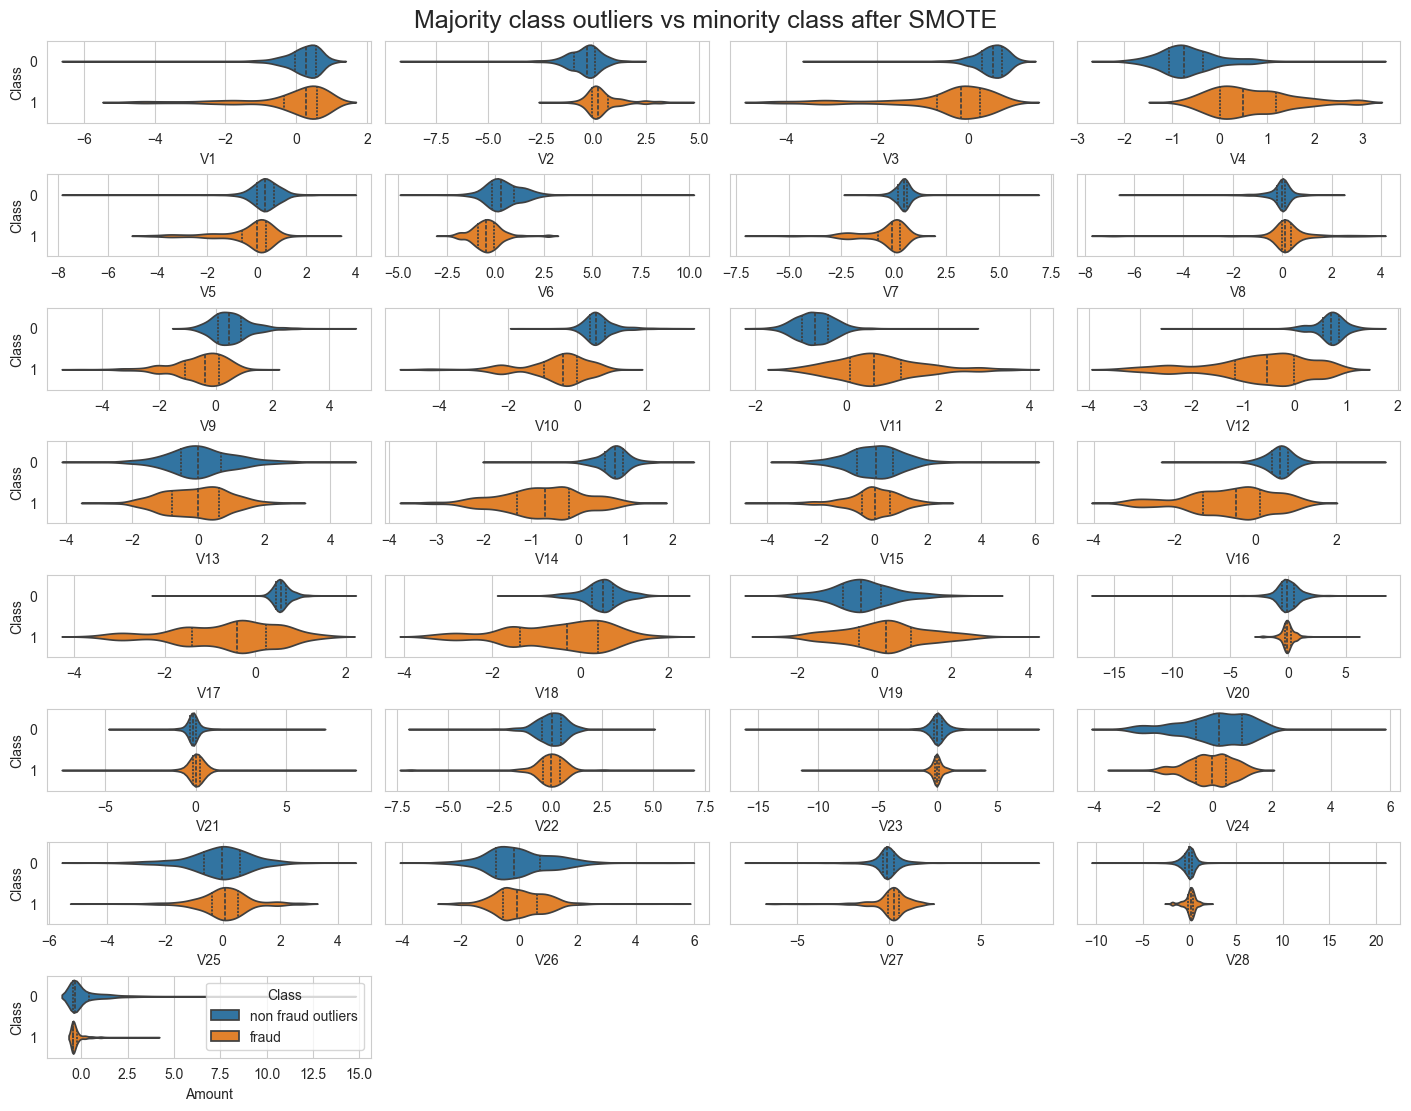

In [35]:
show_violinplots(d=newOutData, x=newOutData.columns[:-1], y='Class', size=[14,11], legend=['non fraud outliers', 'fraud'], title='Majority class outliers vs minority class after SMOTE')
minor_outlier_feat = find_removable_featues(newOutData, mean_thresh=.2)
minor_outlier_feat

#### Removing the features that showed similarity in our normal training data

In [36]:
clf_out, x_train_out_smote, y_train_out_smote, scaler_out = train(x_train_out_.drop(columns=minor_feat), y_train_out_, LR_model_2, smote) 
smote_metrics_s_r0_out = eval_model(scaler_out.transform(x_test_out.drop(columns=minor_feat)), y_test_out, clf_out)
pd.DataFrame(smote_metrics_s_r0_out).T

,precision_score,recall_score,roc_auc_score,average_precision_score,f1_score,fbeta_score_3,fbeta_score_5,fbeta_score_10
0,0.84507,0.810811,0.904185,0.688249,0.827586,0.814111,0.812077,0.811136


#### Removing the features that showed similarity in our outlier training data

In [37]:
clf_out, x_train_out_smote, y_train_out_smote, scaler_out = train(x_train_out_.drop(columns=minor_outlier_feat), y_train_out_, LR_model_2, smote) 
smote_metrics_s_r1_out = eval_model(scaler_out.transform(x_test_out.drop(columns=minor_outlier_feat)), y_test_out, clf_out)
# show_learning_curve(LR_model_2, x_train_out_smote, y_train_out_smote, ['neg_log_loss' , 'f1', 'average_precision'])
pd.DataFrame(smote_metrics_s_r1_out).T

,precision_score,recall_score,roc_auc_score,average_precision_score,f1_score,fbeta_score_3,fbeta_score_5,fbeta_score_10
0,0.824324,0.824324,0.91072,0.682349,0.824324,0.824324,0.824324,0.824324


,precision_score,recall_score,roc_auc_score,average_precision_score,f1_score,fbeta_score_3,fbeta_score_5,fbeta_score_10,model
smote_s_out,0.792208,0.824324,0.910387,0.655875,0.807947,0.820996,0.823041,0.823994,Standardized
smote_s_r1_out,0.845070,0.810811,0.904185,0.688249,0.827586,0.814111,0.812077,0.811136,Stand_Reduced1
smote_s_r2_out,0.824324,0.824324,0.910720,0.682349,0.824324,0.824324,0.824324,0.824324,Stand_Reduced2


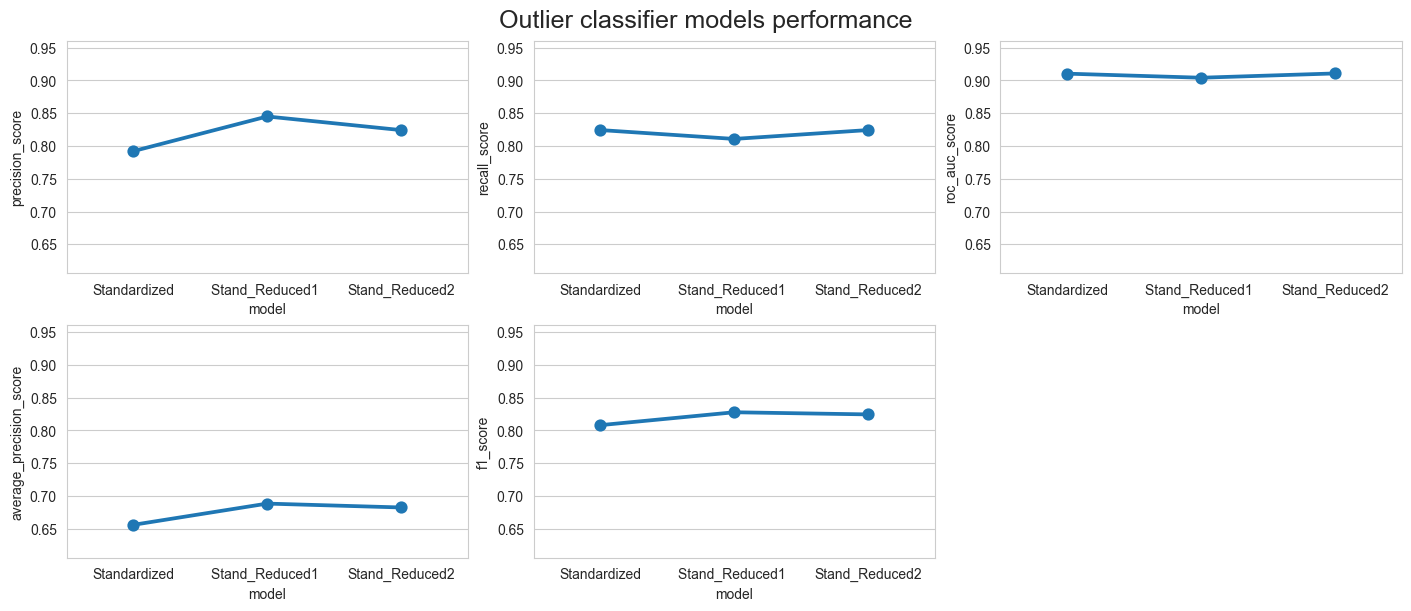

In [38]:
smote_metrics_data_out = pd.DataFrame({'smote_s_out' : smote_metrics_s_out,
                      'smote_s_r1_out' : smote_metrics_s_r0_out,
                      'smote_s_r2_out' : smote_metrics_s_r1_out }).T
smote_metrics_data_out ['model'] = ['Standardized', 'Stand_Reduced1 ', 'Stand_Reduced2']
compare_model_results(smote_metrics_data_out, x='model', y=smote_metrics_data_out.columns[:-4], r=2, c=3, size=[14,6], title='Outlier classifier models performance')
smote_metrics_data_out

# Ensemble Learning

In [39]:
def eval_model_(y_pred, y_true, funcs='auto', fbeta:List[float]=[3,5,10]): 
    """"""
    if funcs=='auto': funcs=['precision_score', 'recall_score', 'roc_auc_score', 'average_precision_score', 'f1_score']
    d = {func : eval('metrics.'+func)(y_true, y_pred) for func in funcs}
    if fbeta : 
        for beta in fbeta : d['fbeta_score_'+str(beta)] = metrics.fbeta_score(y_true, y_pred, beta=beta)
    return pd.Series(d) 

def final_model_predict_proba(data, model_a, model_b, scaler_a, scaler_b, minor_feat_a, minor_feat_b, log=False):
    """"""
    data_a = scaler_a.transform(data.drop(columns=minor_feat_a))
    data_b = scaler_b.transform(data.drop(columns=minor_feat_b))
    if not log:
        proba_a = pd.DataFrame(model_a.predict_proba(data_a), columns=["A0", "A1"])
        proba_b = pd.DataFrame(model_b.predict_proba(data_b), columns=["B0", "B1"])
    else : 
        proba_a = pd.DataFrame(model_a.predict_log_proba(data_a), columns=["A0", "A1"]).replace({-np.inf: -30, np.inf: 30})
        proba_b = pd.DataFrame(model_b.predict_log_proba(data_b), columns=["B0", "B1"]).replace({-np.inf: -30, np.inf: 30})
    return pd.concat((proba_a, proba_b), axis=1)

def final_model_predict(data, model_a, model_b, scaler_a, scaler_b, minor_feat_a, minor_feat_b, alpha=1, beta=1):
    """"""
    data_a = scaler_a.transform(data.drop(columns=minor_feat_a))
    data_b = scaler_b.transform(data.drop(columns=minor_feat_b))
    decision_a, decision_b = model_a.decision_function(data_a), model_b.decision_function(data_b)
    decision = alpha*decision_a + beta*decision_b 
    return (decision>0).astype(int), decision_a, decision_b 

def final_model_summary(x, y, model_a, model_b, scaler_a, scaler_b, minor_feat_a, minor_feat_b, n):
    """"""
    d={}
    for i in range(n):
        alpha = (1/n) * i
        preds, _, _ =  final_model_predict(x, model_a, model_b, scaler_a, scaler_b, minor_feat_a, minor_feat_b, alpha, 1-alpha)
        d[f'alpha_{alpha:.2f}'] = eval_model_(preds, y)
    return pd.DataFrame.from_dict(d).T

### Linear Ensemble Model

In [40]:
x_test_final, y_test_final = pd.concat([x_test, x_test_out]), pd.concat([y_test, y_test_out]) # Concatenating normal and outlier test data
preds, _, _ = final_model_predict(x_test_final, clf, clf_out, scaler, scaler_out, minor_feat, minor_outlier_feat)
ensemble_metrics_1 = eval_model_(preds, y_test_final)
display(pd.DataFrame(ensemble_metrics_1).T)

final_model_eval = final_model_summary(x_test_final, y_test_final, clf, clf_out, scaler, scaler_out, minor_feat, minor_outlier_feat, 20)
final_model_eval['alpha'] = final_model_eval.index.str[-4:].astype(float)
final_model_eval['beta'] = 1-final_model_eval['alpha']
final_model_eval.head(6)


,precision_score,recall_score,roc_auc_score,average_precision_score,f1_score,fbeta_score_3,fbeta_score_5,fbeta_score_10
0,0.503704,0.918919,0.957888,0.463143,0.650718,0.848939,0.89068,0.91148


,precision_score,recall_score,roc_auc_score,average_precision_score,f1_score,fbeta_score_3,fbeta_score_5,fbeta_score_10,alpha,beta
alpha_0.00,0.903704,0.824324,0.912010,0.745552,0.862191,0.831629,0.827119,0.825042,0.00,1.00
alpha_0.05,0.890511,0.824324,0.911986,0.734677,0.856140,0.830497,0.826688,0.824931,0.05,0.95
alpha_0.10,0.892086,0.837838,0.918743,0.747984,0.864111,0.842964,0.839802,0.838343,0.10,0.90
alpha_0.15,0.895105,0.864865,0.932257,0.774612,0.879725,0.867797,0.865990,0.865154,0.15,0.85
alpha_0.20,0.890411,0.878378,0.939002,0.782538,0.884354,0.879567,0.878835,0.878496,0.20,0.80
alpha_0.25,0.870130,0.905405,0.952468,0.788147,0.887417,0.901750,0.903996,0.905042,0.25,0.75


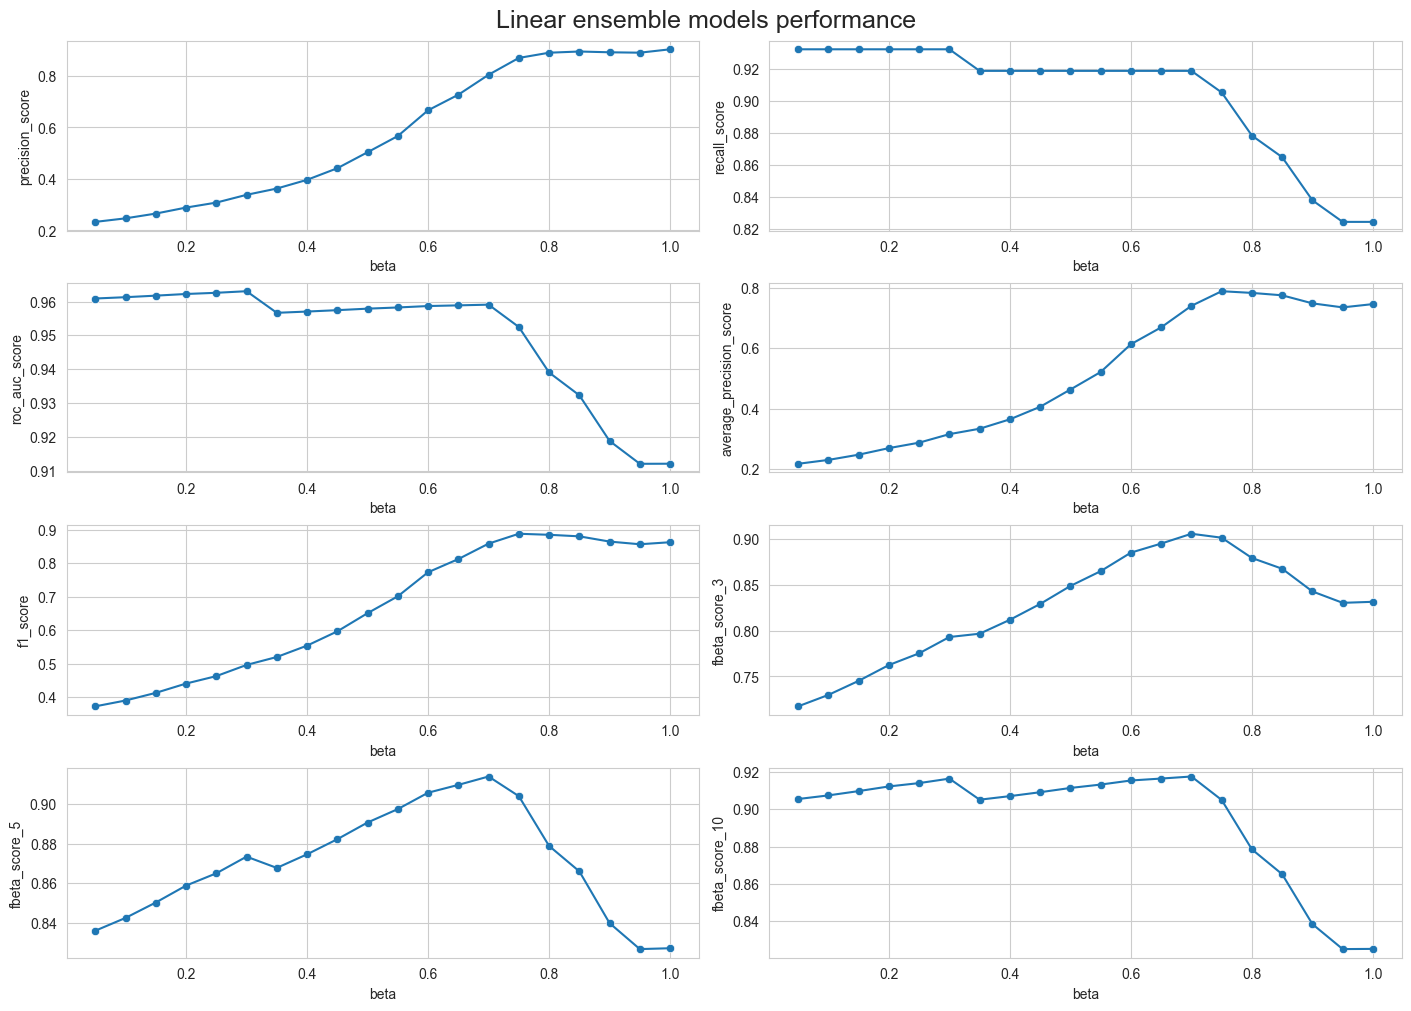

In [41]:
def show_lineplots(data, x, y, r=4, c=2, size=[14,10], title=''):
    fig, ax = plt.subplots(r,c, figsize=size, constrained_layout=True)
    ranges = [(i,j) for i in range(r) for j in range(c)]
    for y_,(i,j) in zip(y, ranges) : 
        sns.lineplot(ax=ax[i,j], data=data, x=x, y=y_)
        sns.scatterplot(ax=ax[i,j], data=data, x=x, y=y_)
    fig.suptitle(title, size=18)
show_lineplots(final_model_eval, x='beta', y=final_model_eval.columns, title='Linear ensemble models performance')


# Model Stacking 
<!-- ## Modeling with extra steps ;p -->
### Method 1: Using decision function

In [42]:
%%capture --no-stdout

x_train_final_A = np.concat([x_train_smote, x_train_out_smote[y_train_out_smote==0][...,:-1]])
x_train_final_B, _ = shuffle(*smote.fit_resample(x_train_.drop(columns=minor_outlier_feat), y_train_), random_state=SEED)
x_train_final_B = np.concat([scaler_out.transform(x_train_final_B), x_train_out_smote[y_train_out_smote==0]])
y_train_final = np.concat([y_train_smote.to_numpy(), y_train_out_smote[y_train_out_smote==0]])

x_train_from_models_dec = pd.DataFrame.from_dict({
    'model_A': clf.decision_function(x_train_final_A),
    'model_B': clf_out.decision_function(x_train_final_B)
    })

big_model = LogisticRegression(class_weight={0: 8, 1: 1}, penalty='l2', random_state=SEED, max_iter=LR_EPOCHS)
big_clf = big_model.fit(x_train_from_models_dec, y_train_final)
print('--- TRAINING ---\n', eval_model(x_train_from_models_dec, y_train_final, big_clf), sep='')

_, tmp_a, tmp_b = final_model_predict(x_test_final, clf, clf_out, scaler, scaler_out, minor_feat, minor_outlier_feat)
x_test_from_models = np.concat([tmp_a, tmp_b]).reshape(2,-1).transpose()
print('\n--- VALIDATION ---\n', eval_model(x_test_from_models, y_test_final, big_clf), sep='')

--- TRAINING ---
precision_score            0.997089
recall_score               0.819511
roc_auc_score              0.908927
average_precision_score    0.890962
f1_score                   0.899621
fbeta_score_3              0.834371
fbeta_score_5              0.825163
fbeta_score_10             0.820959
dtype: float64

--- VALIDATION ---
precision_score            0.850000
recall_score               0.918919
roc_auc_score              0.959178
average_precision_score    0.781361
f1_score                   0.883117
fbeta_score_3              0.911528
fbeta_score_5              0.916062
fbeta_score_10             0.918182
dtype: float64


### Method 2 
#### i - Using prediction probability

In [43]:
x_train_from_models = pd.concat(
    (pd.DataFrame(clf.predict_proba(x_train_final_A), columns=["A0", "A1"]),
     pd.DataFrame(clf_out.predict_proba(x_train_final_B), columns=["B0", "B1"])),
     axis=1
)

big_model = LogisticRegression(class_weight={0: 8, 1: 1}, penalty='l2', random_state=SEED, max_iter=LR_EPOCHS)
big_clf = big_model.fit(x_train_from_models, y_train_final)
print('--- TRAINING ---\n', eval_model(x_train_from_models, y_train_final, big_clf), sep='')

x_test_from_models = final_model_predict_proba(x_test_final, clf, clf_out, scaler, scaler_out, minor_feat, minor_outlier_feat)
print('\n--- VALIDATION ---\n', eval_model(x_test_from_models, y_test_final, big_clf), sep='')


--- TRAINING ---
precision_score            0.997105
recall_score               0.824030
roc_auc_score              0.911187
average_precision_score    0.893632
f1_score                   0.902343
fbeta_score_3              0.838586
fbeta_score_5              0.829568
fbeta_score_10             0.825448
dtype: float64

--- VALIDATION ---
precision_score            0.844156
recall_score               0.878378
roc_auc_score              0.938908
average_precision_score    0.741909
f1_score                   0.860927
fbeta_score_3              0.874832
fbeta_score_5              0.877011
fbeta_score_10             0.878026
dtype: float64


##### ii - Using predicition log probability

In [44]:
%%capture --no-stdout

x_train_from_models = pd.concat(
    (pd.DataFrame(clf.predict_log_proba(x_train_final_A), columns=["A0", "A1"]),
     pd.DataFrame(clf_out.predict_log_proba(x_train_final_B), columns=["B0", "B1"])),
     axis=1
)

x_train_from_models.replace({-np.inf: -30, np.inf: 30}, inplace=True)

big_model = LogisticRegression(class_weight={0: downsample_factor, 1: 1}, penalty='l2', random_state=SEED, max_iter=LR_EPOCHS)
big_clf = big_model.fit(x_train_from_models, y_train_final)
print('--- TRAINING ---\n', eval_model(x_train_from_models, y_train_final, big_clf), sep='')

x_test_from_models = final_model_predict_proba(x_test_final, clf, clf_out, scaler, scaler_out, minor_feat, minor_outlier_feat, log=True)
print('\n--- VALIDATION ---\n', eval_model(x_test_from_models, y_test_final, big_clf), sep='')


--- TRAINING ---
precision_score            0.997002
recall_score               0.795587
roc_auc_score              0.896966
average_precision_score    0.876826
f1_score                   0.884979
fbeta_score_3              0.811991
fbeta_score_5              0.801818
fbeta_score_10             0.797182
dtype: float64

--- VALIDATION ---
precision_score            0.866667
recall_score               0.878378
roc_auc_score              0.938955
average_precision_score    0.761682
f1_score                   0.872483
fbeta_score_3              0.877193
fbeta_score_5              0.877922
fbeta_score_10             0.878261
dtype: float64


### Method 3: Training outlier detection model
#### Normal split ( taking only the majority class outliers as outliers )

In [45]:
### Outlier maj split
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(outlier_feat, outlier_target, test_size=TEST_SIZE, random_state=SEED)
y_train_1, y_test_1 = 1-y_train_1, 1-y_test_1 

### Normal data split
x_train_2, x_test_2, y_train_2, y_test_2 = x_train.copy(), x_test.copy(), np.zeros(len(y_train)), np.zeros(len(y_test))

x_train_o, x_test_o = pd.concat((x_train_1, x_train_2)).reset_index(drop=True), pd.concat((x_test_1, x_test_2)).reset_index(drop=True)
y_train_o, y_test_o =  pd.Series(np.concat((y_train_1, y_train_2))), pd.Series(np.concat((y_test_1, y_test_2)))
x_train_o.shape, y_train_o.shape, x_test_o.shape, y_test_o.shape

((242085, 29), (242085,), (42722, 29), (42722,))

In [46]:
%%capture --no-stdout

### Modeling oulier detector model
downsample_factor_o, sample_ratio_o = get_downsampling_factor(y_train_o, maj_ratio=.5)
x_train_o_, y_train_o_ = downsample(x_train_o, y_train_o, sample_ratio_o)
LR_model_o = LogisticRegression(class_weight={0: downsample_factor_o, 1: 1}, penalty='l2', random_state=SEED, max_iter=LR_EPOCHS)
clf_o, x_train_o_, y_train_o_, scaler_o = train(x_train_o_, y_train_o_, LR_model_o, None, True)
x_test_o_ = scaler_o.transform(x_test_o)

### Oulier detector model evaluation
print(eval_model(x_test_o_, y_test_o, clf_o),'\n')

### Stacked model evaluation ( Ensembling with outlier detector proba as weights )
x_test_final, y_test_final = pd.concat([x_test, x_test_out]), pd.concat([y_test, y_test_out])
preds, _, _ = final_model_predict(x_test_final, clf, clf_out, scaler, scaler_out, minor_feat, minor_outlier_feat,
                                   alpha=clf_o.predict_proba(x_test_final)[:,0], beta=clf_o.predict_proba(x_test_final)[:,1])
print(eval_model_(preds, y_test_final))


precision_score            0.849237
recall_score               0.691300
roc_auc_score              0.838415
average_precision_score    0.619637
f1_score                   0.762173
fbeta_score_3              0.704401
fbeta_score_5              0.696281
fbeta_score_10             0.692576
dtype: float64 

precision_score            0.905109
recall_score               0.837838
roc_auc_score              0.918767
average_precision_score    0.758896
f1_score                   0.870175
fbeta_score_3              0.844112
fbeta_score_5              0.840240
fbeta_score_10             0.838455
dtype: float64


#### Alternative split ( splitting all classes into normal and outliers )    

In [47]:
clean_min_data, outlier_min_data = remove_outliers_all(final_outlier_data[final_outlier_data.Class==1], minQ[1:], maxQ[1:])

### Outlier maj + min split
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(outlier_feat, outlier_target, test_size=TEST_SIZE, random_state=SEED)
x_train_1 = pd.concat((x_train_1, outlier_min_data.drop(columns='Class')))
y_train_1, y_test_1 = np.ones(len(y_train_1)+len(outlier_min_data)), np.ones(len(y_test_1))

### Normal data split
x_train_2, x_test_2 = pd.concat((x_train[y_train==0], clean_min_data.drop(columns='Class'))), x_test.copy(), 
y_train_2, y_test_2 = np.zeros(len(y_train[y_train==0])+len(clean_min_data)), np.zeros(len(y_test))

### Concatenating sets
x_train_o, x_test_o = pd.concat((x_train_1, x_train_2)).reset_index(drop=True), pd.concat((x_test_1, x_test_2)).reset_index(drop=True)
y_train_o, y_test_o =  pd.Series(np.concat((y_train_1, y_train_2))), pd.Series(np.concat((y_test_1, y_test_2)))
x_train_o.shape, y_train_o.shape, x_test_o.shape, y_test_o.shape

### Modeling oulier detector model
downsample_factor_o, sample_ratio_o = get_downsampling_factor(y_train_o, maj_ratio=.5) # only downsample (no smote)
x_train_o_, y_train_o_ = downsample(x_train_o, y_train_o, sample_ratio_o)
LR_model_o = LogisticRegression(class_weight={0: downsample_factor_o, 1: 1}, penalty='l2', random_state=SEED, max_iter=LR_EPOCHS)
clf_o, x_train_o_, y_train_o_, scaler_o = train(x_train_o_, y_train_o_, LR_model_o, None, True)
x_test_o_ = scaler_o.transform(x_test_o)

### Oulier detector model evaluation
print(eval_model(x_test_o_, y_test_o, clf_o),'\n')

### Stacked model evaluation ( Ensembling with outlier detector proba as weights )
x_test_final, y_test_final = pd.concat([x_test, x_test_out]), pd.concat([y_test, y_test_out])
preds, _, _ = final_model_predict(x_test_final, clf, clf_out, scaler, scaler_out, minor_feat, minor_outlier_feat,
                                   alpha=clf_o.predict_proba(x_test_final)[:,0], beta=clf_o.predict_proba(x_test_final)[:,1])
print(eval_model_(preds, y_test_final))


precision_score            0.834170
recall_score               0.701065
roc_auc_score              0.842316
average_precision_score    0.616337
f1_score                   0.761847
fbeta_score_3              0.712433
fbeta_score_5              0.705394
fbeta_score_10             0.702175
dtype: float64 

precision_score            0.903704
recall_score               0.824324
roc_auc_score              0.912010
average_precision_score    0.745552
f1_score                   0.862191
fbeta_score_3              0.831629
fbeta_score_5              0.827119
fbeta_score_10             0.825042
dtype: float64


c:\Users\korda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\korda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
